Unsupervised Eye-Tracking Analysis

In the unsupervised portion of this analysis, we first standardized a selection of critical eye-tracking metrics (e.g., fixation duration, fixation count, saccade count, pupil size) from five metric catergories. Next, we employed HDBSCAN clustering to discover natural groupings or hidden strategy types in the data without relying on predefined labels. 

We then visualized these clusters using UMAP dimensionality reduction to interpret their spatial organization clearly.

This method allowed us to objectively identify distinct gaze behavior patterns that could later be associated with cognitive strategies and performance accuracy.

In [22]:
# Load Cleaned and Rated Data
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import math


import matplotlib
print(matplotlib.matplotlib_fname())


# Update path to your cleaned eye-tracking dataset
df = pd.read_csv("../data/eye_tracking_rated.csv")
df.head()

C:\Users\julia\OneDrive - The University of Alabama\Research\202506-ML-EyeTracking\notebooks\.venv\Lib\site-packages\matplotlib\mpl-data\matplotlibrc


RECORDING_SESSION_LABEL  INDEX AVERAGE_BLINK_DURATION  \
0                ET24_066      2                    140   
1                ET24_066      3                    178   
2                ET24_066      4                   5788   
3                ET24_066      5                  13560   
4                ET24_066      6                   7765   

  AVERAGE_FIXATION_DURATION AVERAGE_SACCADE_AMPLITUDE  AVERAGE_X_RESOLUTION  \
0                    366.88                      5.45                 56.87   
1                    354.98                      5.54                 56.73   
2                         .                     12.28                 59.00   
3                         .                      12.4                 58.40   
4                    206.57                      8.63                 53.41   

   AVERAGE_Y_RESOLUTION  BLINK_COUNT  BUTTON_PRESS_COUNT  \
0                 57.27            3                   0   
1                 57.10            5                   0   
2                 57.80            1                   0   
3                 57.50            1                   0   
4                 53.66            2                   0   

   BUTTON_RELEASE_COUNT  ... START_TIME  TRIAL_LABEL  \
0                     0  ...   92190160     Trial: 2   
1                     0  ...   92216758     Trial: 3   
2                     0  ...   92242664     Trial: 4   
3                     0  ...   92250758     Trial: 5   
4                     0  ...   92266772     Trial: 6   

   VISITED_INTEREST_AREA_COUNT Session_Name_  Trial_Index_   result trialid  \
0                            6      ET24_066             1  choice5       4   
1                            6      ET24_066             2  choice1      12   
2                            0      ET24_066             3  choice3       1   
3                            0      ET24_066             4  choice3      18   
4                            5      ET24_066             5  choice3       6   

  key response_num response  
0   5          5.0        1  
1   1          1.0        1  
2   3          3.0        1  
3   1          3.0        0  
4   3          3.0        1  

[5 rows x 71 columns]

In [7]:
# Select variables
variables = [
    "RECORDING_SESSION_LABEL",
    "trialid",
    "response",
    "AVERAGE_FIXATION_DURATION",
    "FIXATION_COUNT",
    "FIXATION_DURATION_MAX",
    "FIXATION_DURATION_MIN",
    "MEDIAN_FIXATION_DURATION",
    "SD_FIXATION_DURATION",
    "AVERAGE_SACCADE_AMPLITUDE",
    "MEDIAN_SACCADE_AMPLITUDE",
    "SACCADE_COUNT",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN",
    "PUPIL_SIZE_MAX",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION",
    "BLINK_COUNT",
    "RUN_COUNT",
    "IA_COUNT",
    "VISITED_INTEREST_AREA_COUNT",
    "DURATION",
    "IP_DURATION"
]

# Extract selected metrics
df_selected = df[variables]

df_selected.head()

df_selected.to_csv("../data/eye_tracking_metrics_selected.csv", index=False)

In [9]:
# Replace "." with np.nan without inplace
df_selected = df_selected.replace(".", np.nan)

# Create a copy of the dataframe to store numeric values
df_selected_numeric = df_selected.copy()  # Create df_selected_numeric first

exclude_columns = ['RECORDING_SESSION_LABEL', 'trialid', 'response']

# Convert columns to numeric and then to int64 where possible
for col in df_selected.columns:
    # Skip the columns we want to keep as is
    if col not in exclude_columns:
        # First convert to numeric (this will create float values)
        df_selected_numeric[col] = pd.to_numeric(df_selected[col], errors='coerce')
    
# Check the result
#df_selected_numeric.info()
df_selected_numeric.head()

RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                ET24_066        4         1                     366.88   
1                ET24_066       12         1                     354.98   
2                ET24_066        1         1                        NaN   
3                ET24_066       18         0                        NaN   
4                ET24_066        6         1                     206.57   

   FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0              57                 1011.0                   90.0   
1              57                 1134.0                   36.0   
2               0                    NaN                    NaN   
3               0                    NaN                    NaN   
4               7                  416.0                    8.0   

   MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  AVERAGE_SACCADE_AMPLITUDE  \
0                     368.0                198.33                       5.45   
1                     308.0                206.06                       5.54   
2                       NaN                   NaN                      12.28   
3                       NaN                   NaN                      12.40   
4                     234.0                142.05                       8.63   

   ...  PUPIL_SIZE_MEAN  PUPIL_SIZE_MAX  PUPIL_SIZE_MIN  \
0  ...           597.68           691.0           530.0   
1  ...           580.97           718.0           503.0   
2  ...              NaN             NaN             NaN   
3  ...              NaN             NaN             NaN   
4  ...           508.65           527.0           491.0   

   AVERAGE_BLINK_DURATION  BLINK_COUNT  RUN_COUNT  IA_COUNT  \
0                   140.0            3         32         7   
1                   178.0            5         26         7   
2                  5788.0            1          0         7   
3                 13560.0            1          0         7   
4                  7765.0            2          5         7   

   VISITED_INTEREST_AREA_COUNT  DURATION  IP_DURATION  
0                            6     23799        23714  
1                            6     23699        23619  
2                            0      5825         5735  
3                            0     13597        13518  
4                            5     17349        17270  

[5 rows x 23 columns]

                              count      mean       std      min      25%  \
AVERAGE_FIXATION_DURATION    1559.0    312.97    307.14    36.00   246.88   
FIXATION_COUNT               1582.0     42.89     36.21     0.00    19.00   
FIXATION_DURATION_MAX        1559.0   1123.83    775.30    36.00   674.00   
FIXATION_DURATION_MIN        1559.0     68.30    303.84     0.00    28.00   
MEDIAN_FIXATION_DURATION     1559.0    246.50    302.38    32.00   200.00   
SD_FIXATION_DURATION         1559.0    227.27    121.25     0.00   154.14   
AVERAGE_SACCADE_AMPLITUDE    1564.0      4.80      1.33     0.00     4.04   
MEDIAN_SACCADE_AMPLITUDE     1579.0      2.84      1.70     0.00     1.67   
SACCADE_COUNT                1582.0     42.13     36.18     0.00    18.00   
SD_SACCADE_AMPLITUDE         1579.0      4.64      1.45     0.00     3.84   
PUPIL_SIZE_MEAN              1558.0    666.45    200.86    45.16   529.56   
PUPIL_SIZE_MAX               1558.0    887.69    475.30    85.00   652.00   

<Figure size 1500x1000 with 0 Axes>

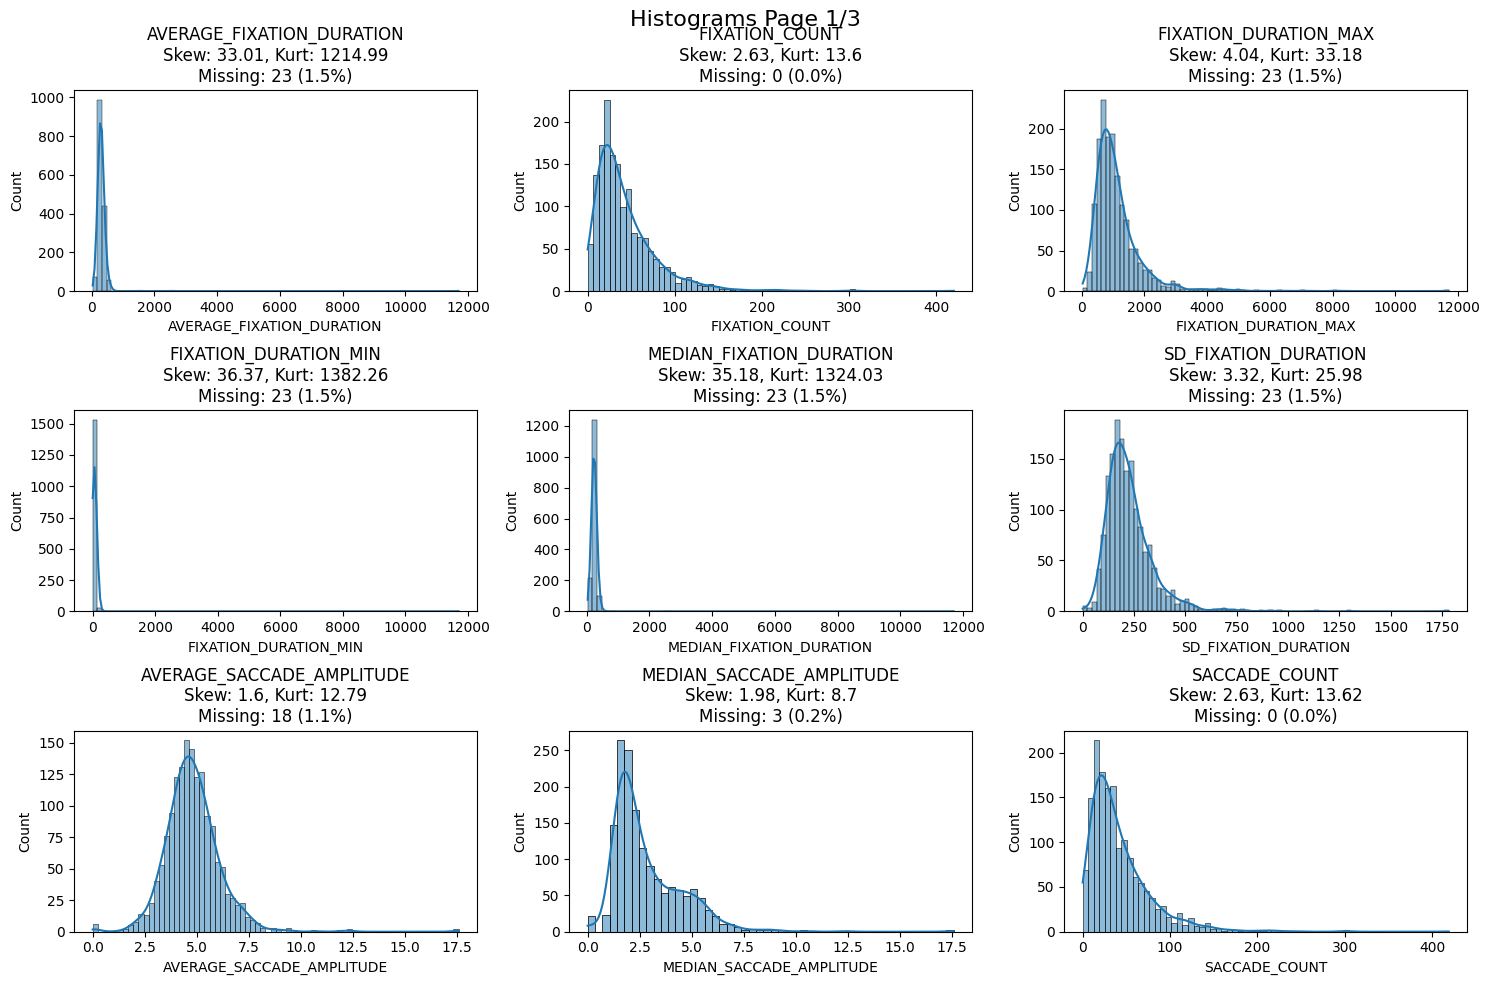

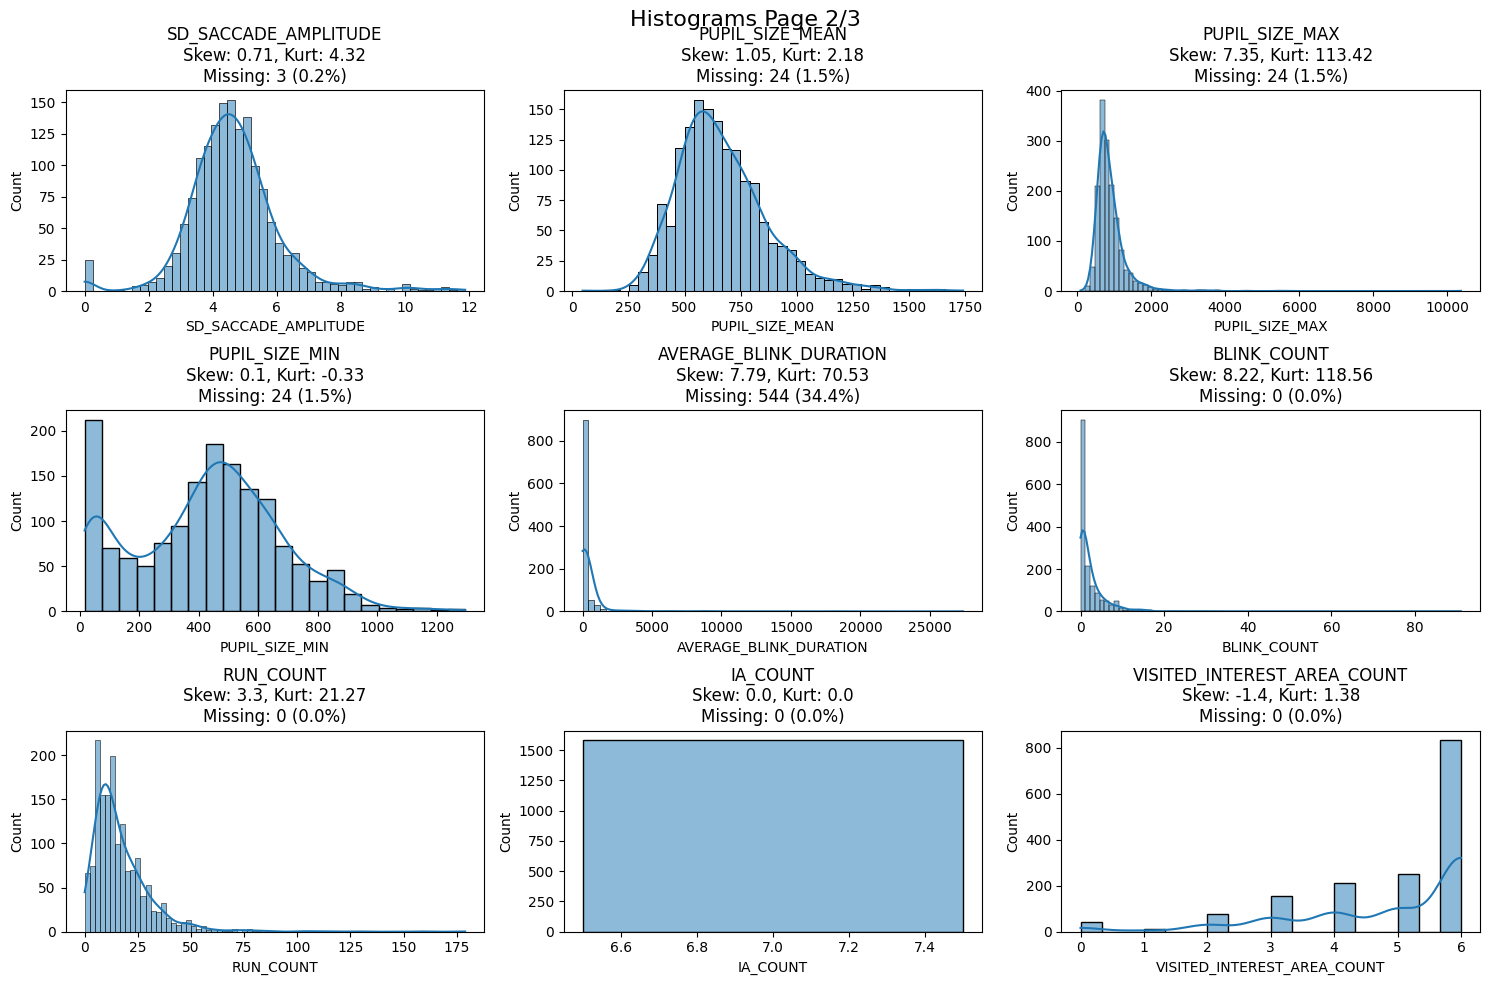

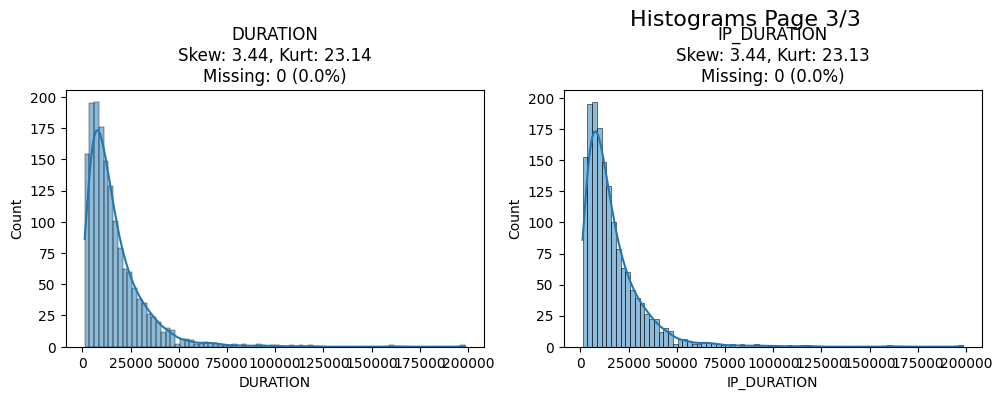

In [10]:
# Select all eye tracking metrics
metrics = [
    "AVERAGE_FIXATION_DURATION",
    "FIXATION_COUNT",
    "FIXATION_DURATION_MAX",
    "FIXATION_DURATION_MIN",
    "MEDIAN_FIXATION_DURATION",
    "SD_FIXATION_DURATION",
    "AVERAGE_SACCADE_AMPLITUDE",
    "MEDIAN_SACCADE_AMPLITUDE",
    "SACCADE_COUNT",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN",
    "PUPIL_SIZE_MAX",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION",
    "BLINK_COUNT",
    "RUN_COUNT",
    "IA_COUNT",
    "VISITED_INTEREST_AREA_COUNT",
    "DURATION",
    "IP_DURATION"
]


# Create a comprehensive descriptive statistics table
def descriptive_stats(df):
    # Filter only numeric columns (both float64 and int64) for statistical calculations
    numeric_df = df[metrics].select_dtypes(include=['float64', 'int64'])

    # Basic statistics
    desc = numeric_df.describe().T
    
    # Add additional statistics
    desc['skewness'] = numeric_df.skew()
    desc['kurtosis'] = numeric_df.kurtosis()
    desc['median'] = numeric_df.median()
    desc['variance'] = numeric_df.var()
    desc['range'] = numeric_df.max() - numeric_df.min()
    desc['IQR'] = numeric_df.quantile(0.75) - numeric_df.quantile(0.25)
    desc['missing'] = numeric_df.isna().sum()
    desc['missing_pct'] = (numeric_df.isna().sum() / len(numeric_df)) * 100
    
    # Round all values to 2 decimal places for better readability
    desc = desc.round(2)
    
    return desc

# Apply the function to your dataframe
descriptive_table = descriptive_stats(df_selected_numeric)

# Display the table
print(descriptive_table)

# Output descriptive table of metrics
descriptive_table.to_csv("../data/eye_tracking_metrics_descriptive.csv", index=True)


# For a more visual representation, you can also create histograms with density plots to visualize skewness
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))


# Get only numeric columns
numeric_columns = df_selected_numeric.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate skewness for all numeric columns
skewness_values = df_selected_numeric[numeric_columns].skew()

# Option 1: Show all metrics with multiple pages of plots
def plot_all_histograms(df, columns, plots_per_page=9):
    num_pages = math.ceil(len(columns) / plots_per_page)
    
    for page in range(num_pages):
        plt.figure(figsize=(15, 10))
        start_idx = page * plots_per_page
        end_idx = min((page + 1) * plots_per_page, len(columns))
        
        for i, column in enumerate(columns[start_idx:end_idx]):
            plt.subplot(3, 3, i + 1)
            sns.histplot(df[column].dropna(), kde=True)
            
            # Add multiple statistics to the title
            skew = df[column].skew().round(2)
            kurt = df[column].kurtosis().round(2)
            missing = df[column].isna().sum()
            missing_pct = (missing / len(df) * 100).round(1)
            
            plt.title(f'{column}\nSkew: {skew}, Kurt: {kurt}\nMissing: {missing} ({missing_pct}%)')
            plt.tight_layout()
        
        plt.suptitle(f'Histograms Page {page+1}/{num_pages}', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()


# Execute one of the functions:
# For all metrics:
plot_all_histograms(df_selected_numeric, metrics)


### Summary of Metric Issues
Several of the selected eye-tracking and behavioral metrics exhibit significant distributional challenges, including high skewness, elevated kurtosis, negative skewness, and evidence of multimodal distributions. These non-normal characteristics can adversely impact machine learning model performance and may lead to unreliable or biased results if not properly addressed.

| Metric                      | Skew | Kurt | Issue         | Solution        |
|-----------------------------|------|------|---------------|-----------------|
| AVG_FIX_DUR                 | 33.0 |1215  | Extreme skew  | Log             |
| FIX_COUNT                   | 2.6  | 14   | Skew/kurt     | Log             |
| FIX_DUR_MAX                 | 4.0  | 33   | Skew/kurt     | Log             |
| FIX_DUR_MIN                 |36.4  |1382  | Extreme skew  | Log             |
| MED_FIX_DUR                 |35.2  |1324  | Extreme skew  | Log             |
| SD_FIX_DUR                  | 3.3  | 26   | Skew/kurt     | Log             |
| AVG_SACC_AMP                | 1.6  | 13   | Mild skew     | Sqrt            |
| MED_SACC_AMP                | 2.0  | 9    | Mild skew     | Sqrt            |
| SACC_COUNT                  | 2.6  | 14   | Skew/kurt     | Log             |
| SD_SACC_AMP                 | 0.7  | 4    | Mild kurt     | OK              |
| PUPIL_MEAN                  | 1.1  | 2    | Slight skew   | OK              |
| PUPIL_MAX                   | 7.4  |113   | Skew/kurt     | Log             |
| PUPIL_MIN                   | 0.1  |-0.3  | None          | OK              |
| AVG_BLINK_DUR               | 7.8  | 71   | Skew/kurt     | Log             |
| BLINK_COUNT                 | 8.2  |119   | Skew/kurt     | Log             |
| RUN_COUNT                   | 3.3  | 21   | Skew/kurt     | Log             |
| IA_COUNT                    | 0.0  | 0    | Constant      | Remove          |
| VISITED_IA_COUNT            |-1.4  | 1.4  | Neg. skew     | Reflect         |
| DURATION                    | 3.4  | 23   | Skew/kurt     | Log             |
| IP_DURATION                 | 3.4  | 23   | Skew/kurt     | Log             |

### Data is df_selected_numeric


In [11]:
# Map for transformations and suffixes
transforms = {
    "AVERAGE_FIXATION_DURATION":     ("log",       lambda x: np.log1p(x)),
    "FIXATION_COUNT":                ("log",       lambda x: np.log1p(x)),
    "FIXATION_DURATION_MAX":         ("log",       lambda x: np.log1p(x)),
    "FIXATION_DURATION_MIN":         ("log",       lambda x: np.log1p(x)),
    "MEDIAN_FIXATION_DURATION":      ("log",       lambda x: np.log1p(x)),
    "SD_FIXATION_DURATION":          ("log",       lambda x: np.log1p(x)),
    "AVERAGE_SACCADE_AMPLITUDE":     ("sqrt",      lambda x: np.sqrt(x)),
    "MEDIAN_SACCADE_AMPLITUDE":      ("sqrt",      lambda x: np.sqrt(x)),
    "SACCADE_COUNT":                 ("log",       lambda x: np.log1p(x)),
    "SD_SACCADE_AMPLITUDE":          (None,        None),        # OK, no action needed
    "PUPIL_SIZE_MEAN":               (None,        None),        # OK, no action needed
    "PUPIL_SIZE_MAX":                ("log",       lambda x: np.log1p(x)),
    "PUPIL_SIZE_MIN":                (None,        None),        # OK, no action needed
    "AVERAGE_BLINK_DURATION":        ("log",       lambda x: np.log1p(x)),
    "BLINK_COUNT":                   ("log",       lambda x: np.log1p(x)),
    "RUN_COUNT":                     ("log",       lambda x: np.log1p(x)),
    "IA_COUNT":                      ("remove",    None),        # Remove
    "VISITED_INTEREST_AREA_COUNT":   ("reflectlog",lambda x: np.log1p(reflect(x))),  # Reflect then log
    "DURATION":                      ("log",       lambda x: np.log1p(x)),
    "IP_DURATION":                   ("log",       lambda x: np.log1p(x)),
}

df_transformed = df_selected_numeric.copy()



def reflect(x):
    return x.max() + 1 - x

for col, (suffix, transform) in transforms.items():
    if col not in df_transformed.columns:
        continue

    if suffix is None:
        continue  # No transformation, keep original
    elif suffix == "remove":
        df_transformed.drop(columns=[col], inplace=True)
    else:
        new_col_name = f"{col}_{suffix}"
        df_transformed[new_col_name] = transform(df_transformed[col])

# keep only transformed columns:
#keep_cols = [f"{col}_{suffix}" for col, (suffix, _) in transforms.items() if suffix not in (None, "remove")]
#df_final = df_transformed[keep_cols]

# View transformed DataFrame
df_transformed.head()


RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                ET24_066        4         1                     366.88   
1                ET24_066       12         1                     354.98   
2                ET24_066        1         1                        NaN   
3                ET24_066       18         0                        NaN   
4                ET24_066        6         1                     206.57   

   FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0              57                 1011.0                   90.0   
1              57                 1134.0                   36.0   
2               0                    NaN                    NaN   
3               0                    NaN                    NaN   
4               7                  416.0                    8.0   

   MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  AVERAGE_SACCADE_AMPLITUDE  \
0                     368.0                198.33                       5.45   
1                     308.0                206.06                       5.54   
2                       NaN                   NaN                      12.28   
3                       NaN                   NaN                      12.40   
4                     234.0                142.05                       8.63   

   ...  AVERAGE_SACCADE_AMPLITUDE_sqrt  MEDIAN_SACCADE_AMPLITUDE_sqrt  \
0  ...                        2.334524                       2.044505   
1  ...                        2.353720                       1.360147   
2  ...                        3.504283                       3.504283   
3  ...                        3.521363                       3.521363   
4  ...                        2.937686                       2.561250   

   SACCADE_COUNT_log  PUPIL_SIZE_MAX_log  AVERAGE_BLINK_DURATION_log  \
0           4.043051            6.539586                    4.948760   
1           4.060443            6.577861                    5.187386   
2           0.693147                 NaN                    8.663715   
3           0.693147                 NaN                    9.514953   
4           2.079442            6.269096                    8.957511   

   BLINK_COUNT_log  RUN_COUNT_log  VISITED_INTEREST_AREA_COUNT_reflectlog  \
0         1.386294       3.496508                                0.693147   
1         1.791759       3.295837                                0.693147   
2         0.693147       0.000000                                2.079442   
3         0.693147       0.000000                                2.079442   
4         1.098612       1.791759                                1.098612   

   DURATION_log  IP_DURATION_log  
0     10.077441        10.073863  
1     10.073230        10.069849  
2      8.670086         8.654517  
3      9.517678         9.511851  
4      9.761348         9.756784  

[5 rows x 38 columns]

## Descriptive summary after transformation

                                         count        mean         std  \
AVERAGE_FIXATION_DURATION_log           1559.0    5.684923    0.306911   
FIXATION_COUNT_log                      1582.0    3.474602    0.855799   
FIXATION_DURATION_MAX_log               1559.0    6.866475    0.548522   
FIXATION_DURATION_MIN_log               1559.0    3.867271    0.773623   
MEDIAN_FIXATION_DURATION_log            1559.0    5.443176    0.304428   
SD_FIXATION_DURATION_log                1559.0    5.311169    0.542014   
AVERAGE_SACCADE_AMPLITUDE_sqrt          1564.0    2.168823    0.308255   
MEDIAN_SACCADE_AMPLITUDE_sqrt           1579.0    1.617905    0.474758   
SACCADE_COUNT_log                       1582.0    3.454023    0.838961   
SD_SACCADE_AMPLITUDE                    1579.0    4.642888    1.446659   
PUPIL_SIZE_MEAN                         1558.0  666.448543  200.861462   
PUPIL_SIZE_MAX_log                      1558.0    6.710114    0.372079   
PUPIL_SIZE_MIN                        

<Figure size 1500x1000 with 0 Axes>

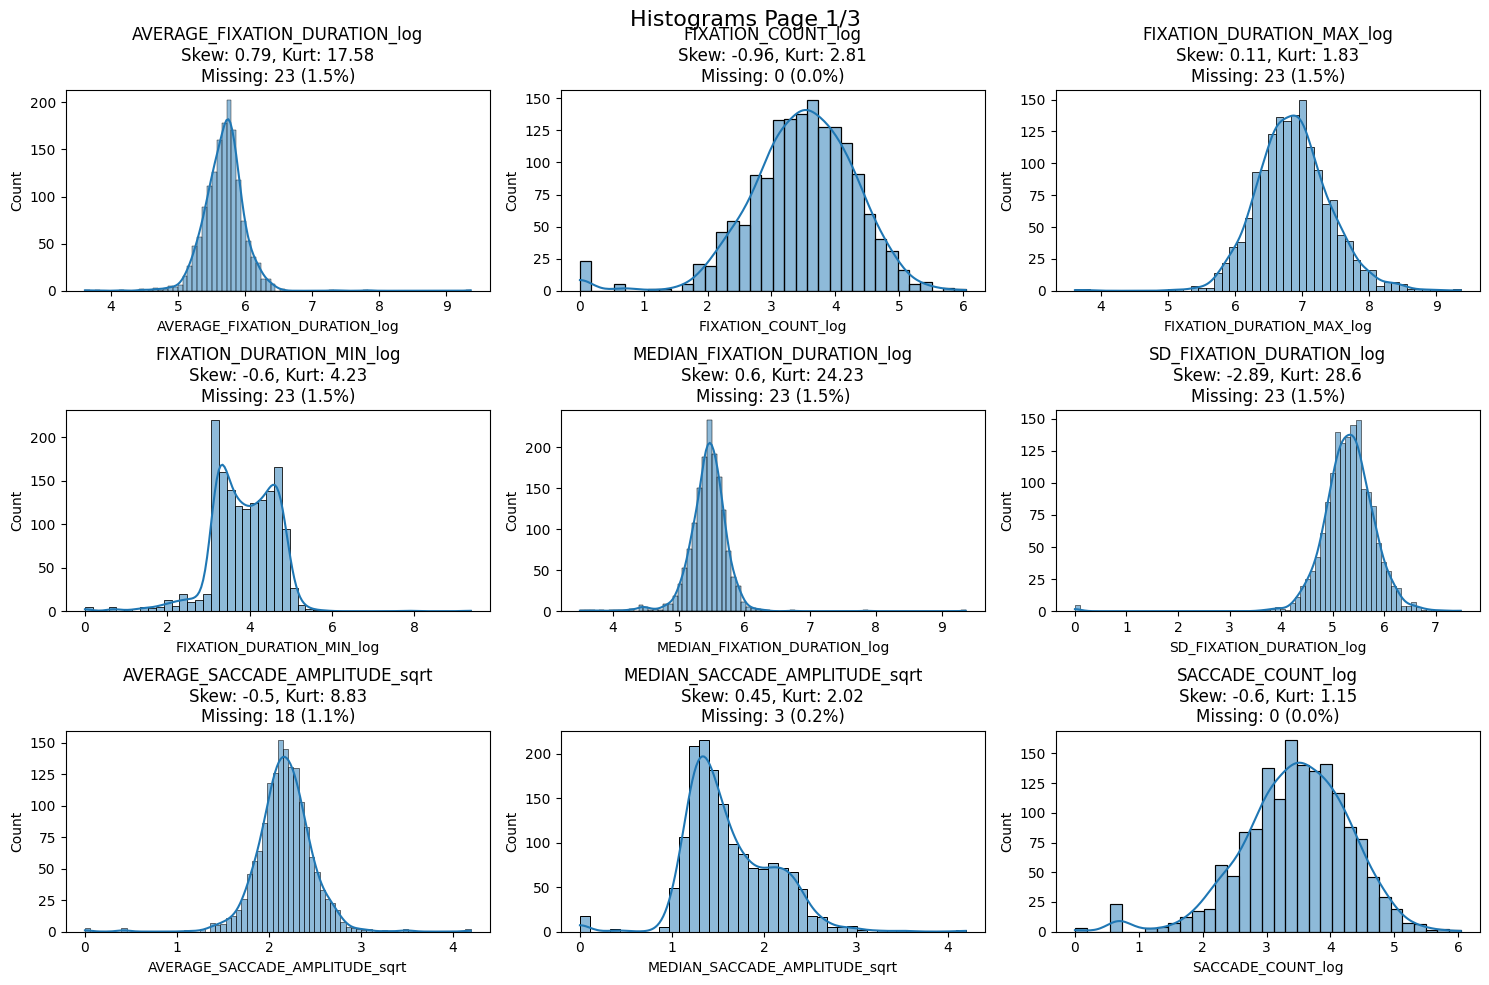

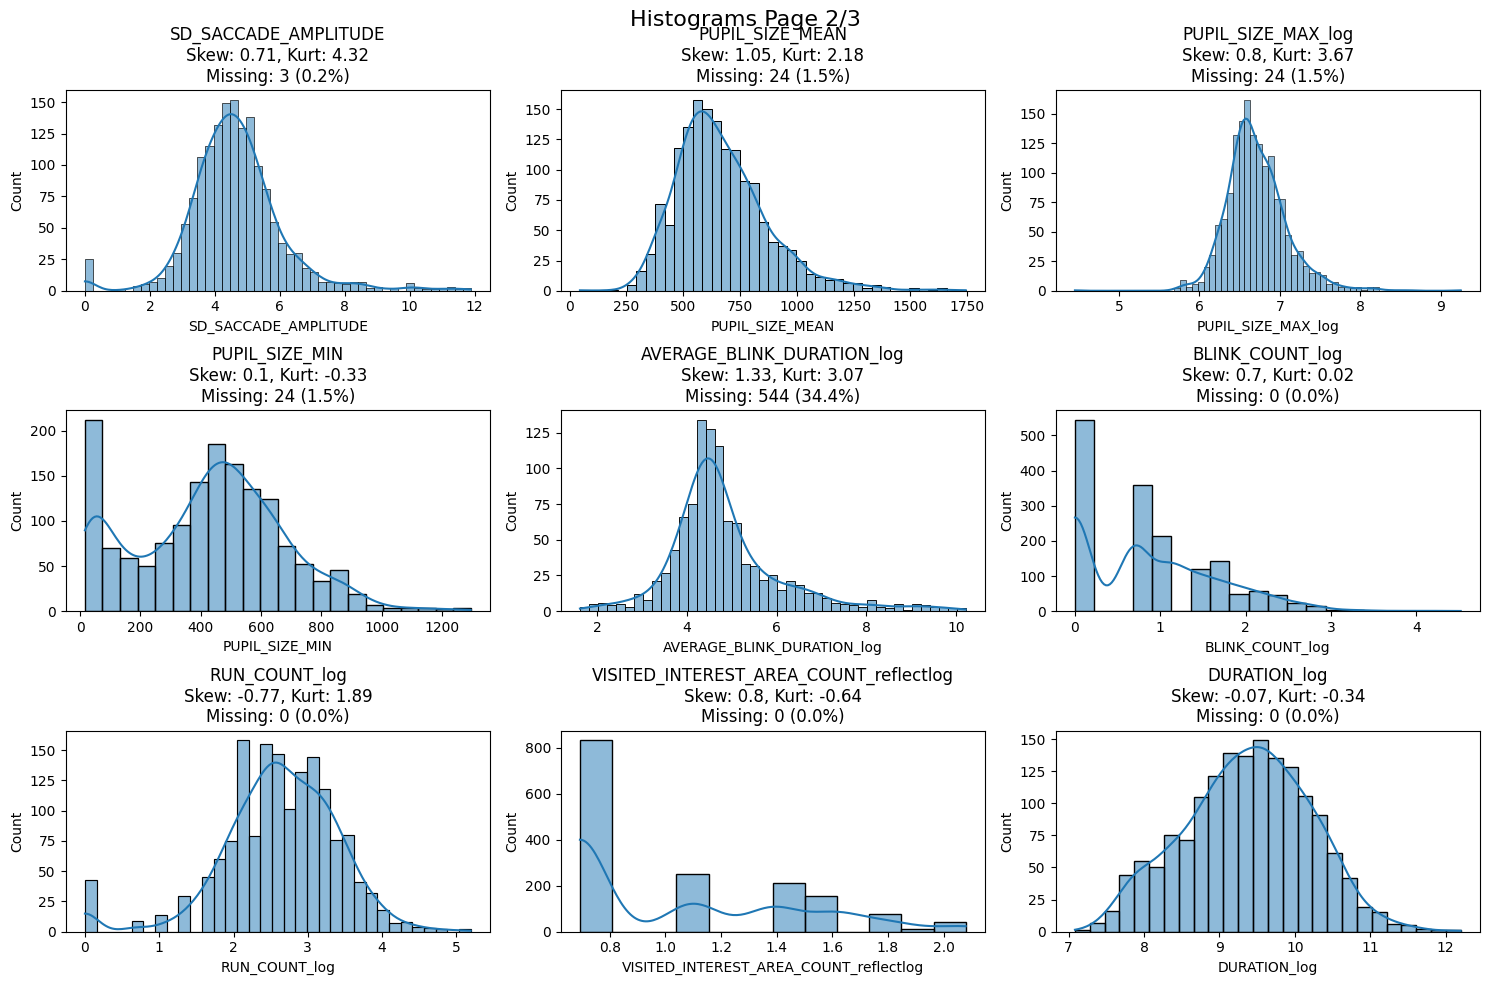

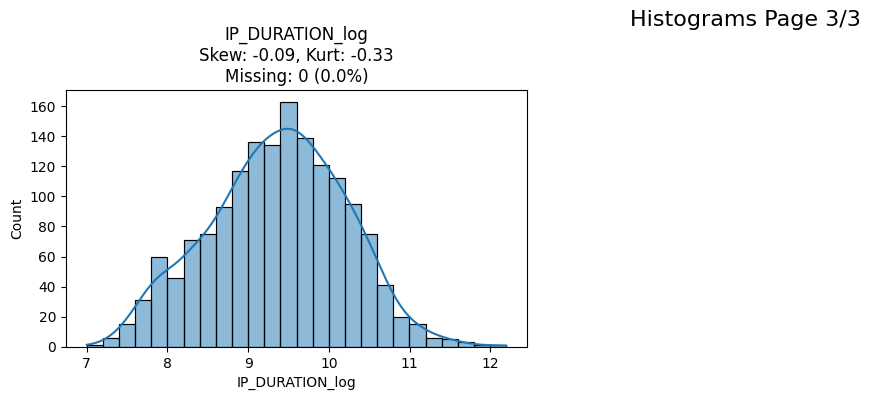

In [12]:
# List of new transformed variables
transformed_vars = [
    "AVERAGE_FIXATION_DURATION_log",
    "FIXATION_COUNT_log",
    "FIXATION_DURATION_MAX_log",
    "FIXATION_DURATION_MIN_log",
    "MEDIAN_FIXATION_DURATION_log",
    "SD_FIXATION_DURATION_log",
    "AVERAGE_SACCADE_AMPLITUDE_sqrt",
    "MEDIAN_SACCADE_AMPLITUDE_sqrt",
    "SACCADE_COUNT_log",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN", 
    "PUPIL_SIZE_MAX_log",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION_log",
    "BLINK_COUNT_log",
    "RUN_COUNT_log",
    "VISITED_INTEREST_AREA_COUNT_reflectlog",
    "DURATION_log",
    "IP_DURATION_log"
]

def descriptive_stats(df):
    # Filter only numeric columns (both float64 and int64) for statistical calculations
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Basic statistics
    desc = numeric_df.describe().T
    desc['skewness'] = numeric_df.skew()
    desc['kurtosis'] = numeric_df.kurtosis()
    return desc

# Apply the function to your dataframe
descriptive_table_transformed = descriptive_stats(df_transformed[transformed_vars])

# Display the table
print(descriptive_table_transformed)

# Output descriptive table of metrics
descriptive_table_transformed.to_csv("../data/eye_tracking_metrics_descriptive_transformed.csv", index=True)



# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Get only numeric columns
numeric_columns = df_transformed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate skewness for all numeric columns
skewness_values = df_transformed[transformed_vars].skew()


# Execute one of the functions:
# For all metrics:
plot_all_histograms(df_transformed, transformed_vars)

## Standardization

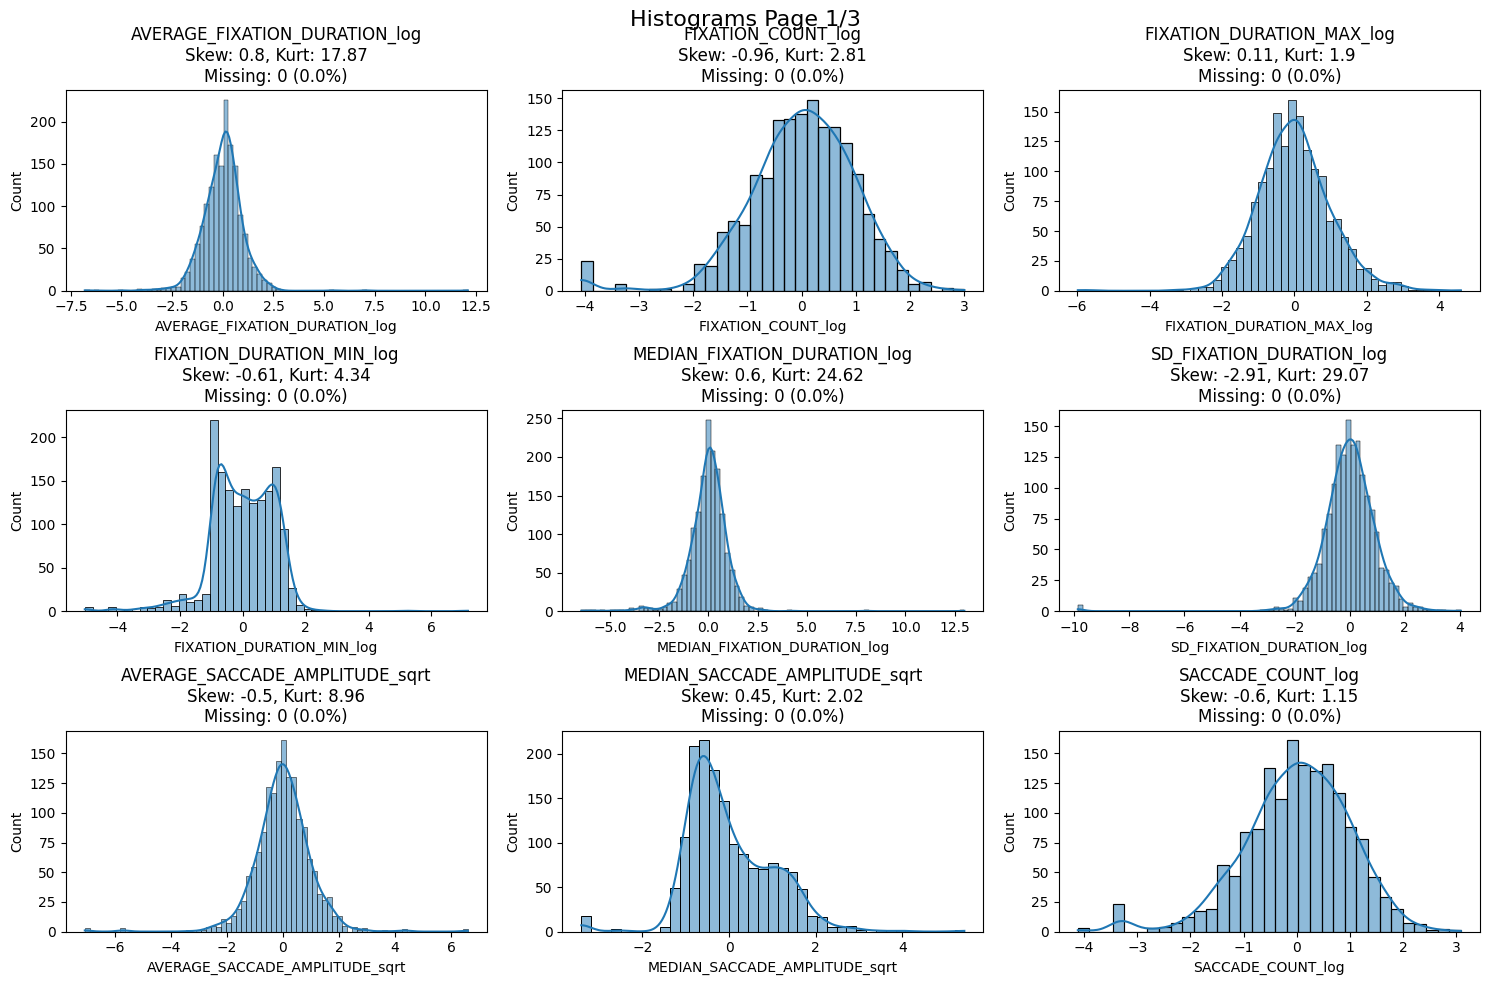

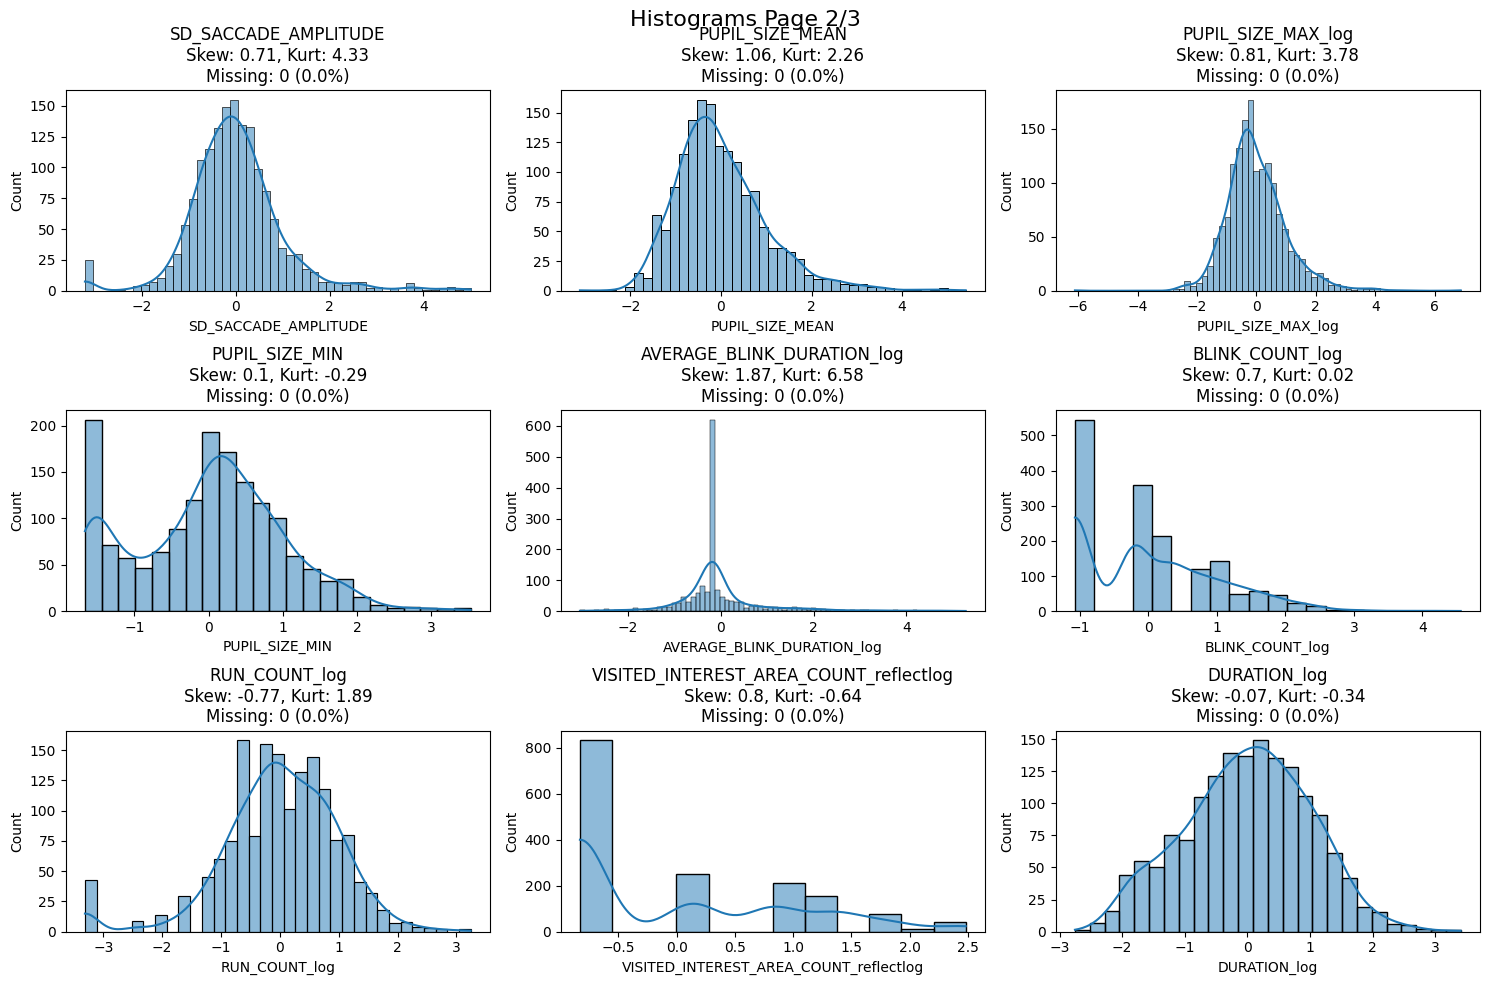

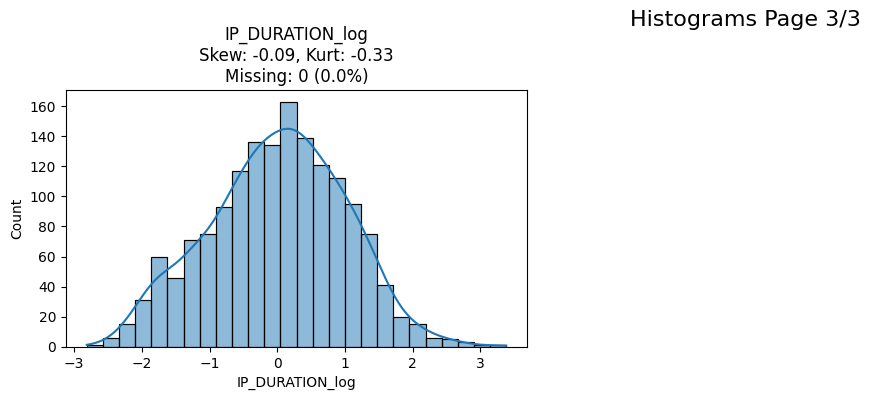

In [14]:
# Decide on imputation strategy (mean/median imputation, KNN, model-based)

# Create a copy for imputation
df_fill = df_transformed.copy()

# Impute missing values
df_fill[transformed_vars] = df_fill[transformed_vars].fillna(df_fill[transformed_vars].median())

# Create a new copy for standardization
df_standardized = df_fill.copy()

# Standardize the selected columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized[transformed_vars] = scaler.fit_transform(df_fill[transformed_vars])

# Plot histograms (fix variable name typo)
plot_all_histograms(df_standardized, transformed_vars)


### Feature Selection or Dimensionality Reduction

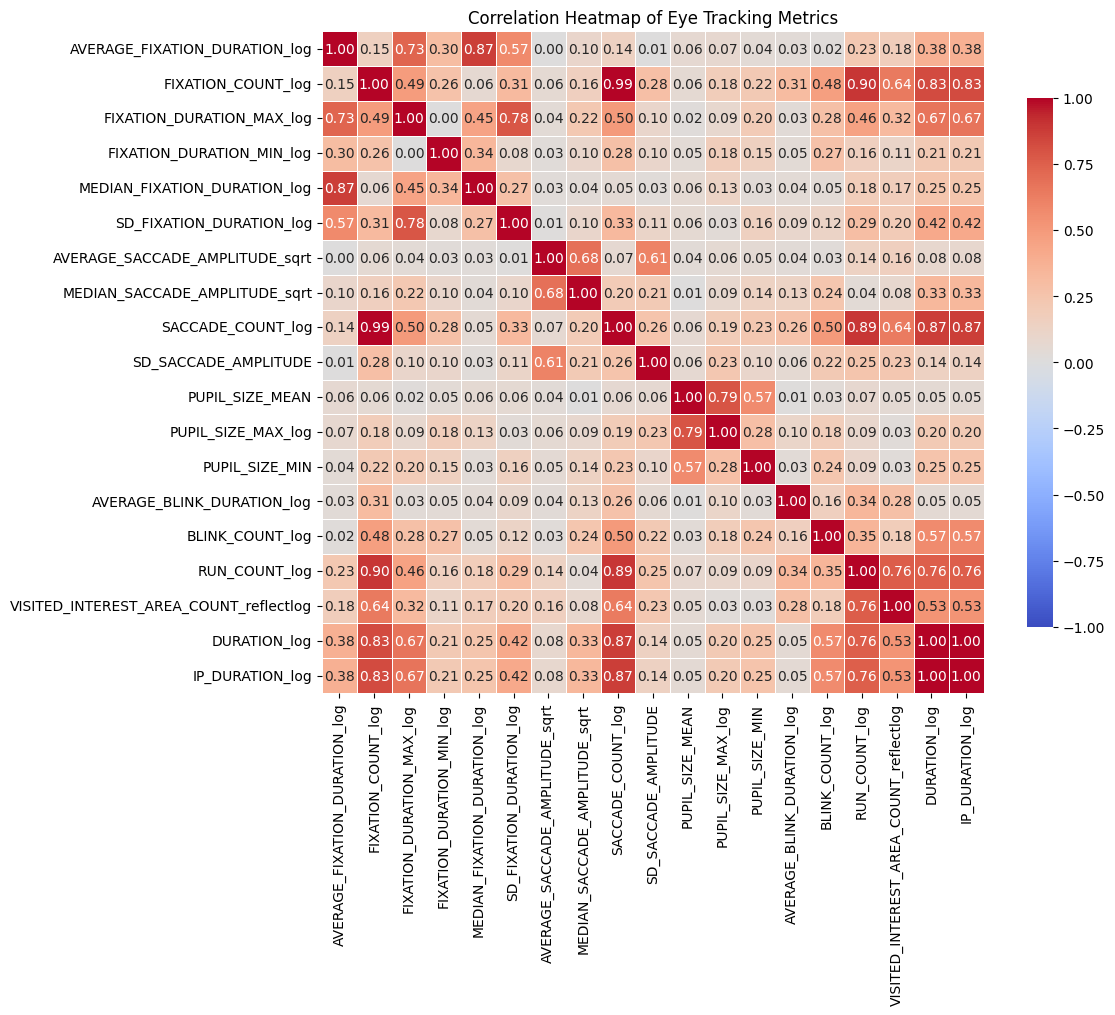

['FIXATION_DURATION_MAX_log', 'MEDIAN_FIXATION_DURATION_log', 'SD_FIXATION_DURATION_log', 'SACCADE_COUNT_log', 'PUPIL_SIZE_MAX_log', 'RUN_COUNT_log', 'VISITED_INTEREST_AREA_COUNT_reflectlog', 'DURATION_log', 'IP_DURATION_log']


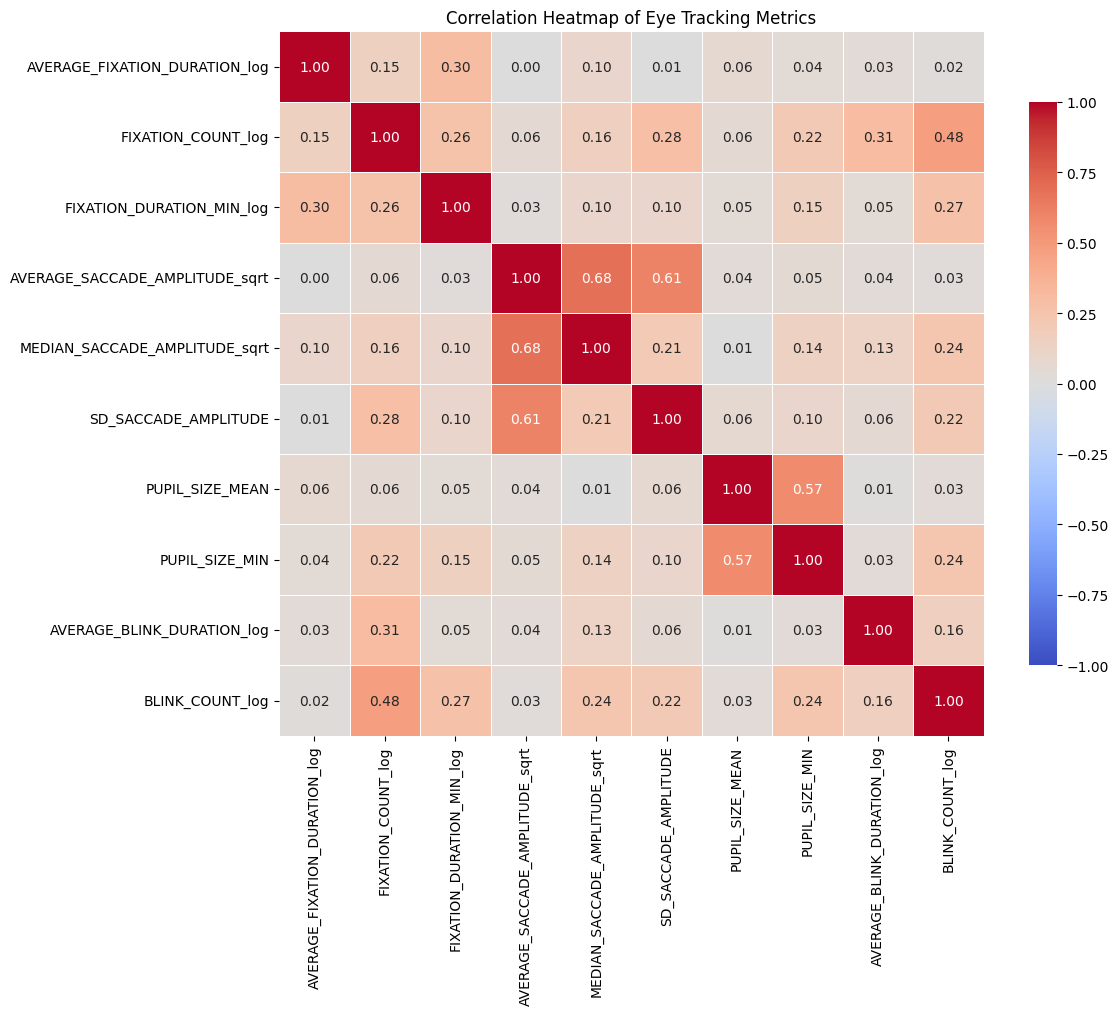

In [15]:
# Use only numeric columns for correlation calculation:
corr_matrix = df_standardized[transformed_vars].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]


# Drop from df_standardized (numeric part only)
df_final = df_standardized.drop(columns=to_drop)



plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,           # Set to False for cleaner look if many variables
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Eye Tracking Metrics")
plt.tight_layout()
plt.show()


print(to_drop)
after_cor_checking_vars = [col for col in transformed_vars if col not in to_drop]


corr_matrix = df_standardized[after_cor_checking_vars].corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,           # Set to False for cleaner look if many variables
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Eye Tracking Metrics")
plt.tight_layout()
plt.show()


### PCA (Principal Component Analysis)

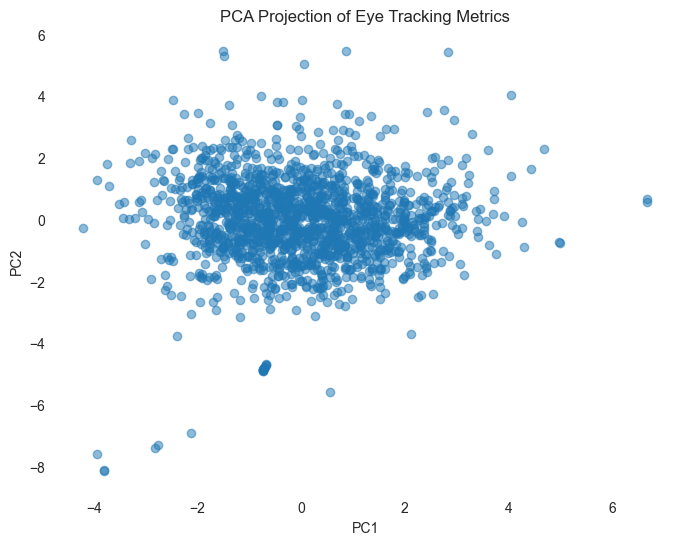

In [19]:
# Now run PCA using the available columns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_standardized[after_cor_checking_vars])

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Eye Tracking Metrics")
plt.show()


### Exploratory Data Analysis (EDA)

### Unsupervised: Cluster analysis (K-means, hierarchical, DBSCAN), PCA, t-SNE, UMAP.

### t-SNE Visualization

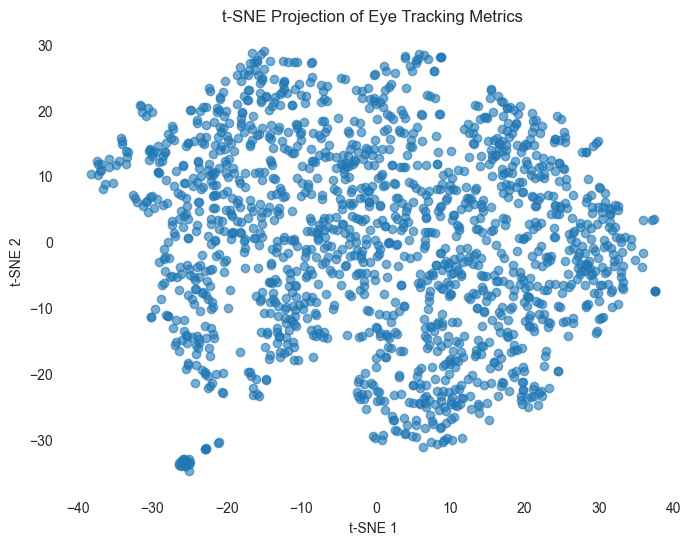

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fit t-SNE (may take 1-2 minutes for large datasets)
tsne = TSNE(n_components=2, perplexity=45, random_state=0)
X_tsne = tsne.fit_transform(df_standardized[after_cor_checking_vars])

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection of Eye Tracking Metrics")
plt.show()



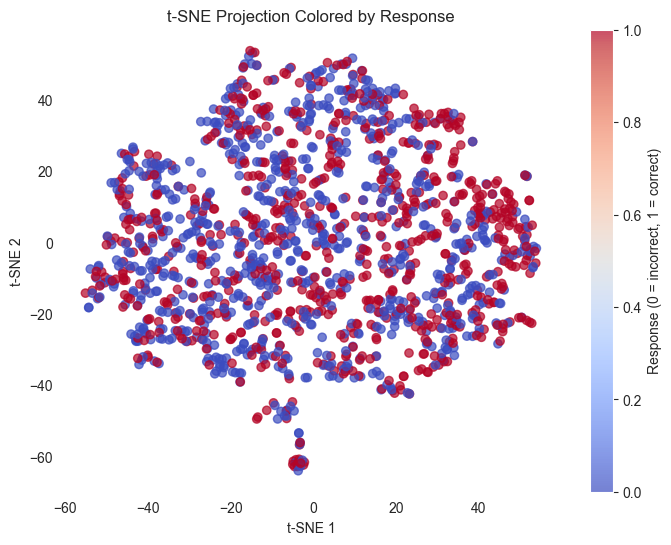

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fit t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(df_standardized[after_cor_checking_vars])

# Plot, colored by response
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=df_standardized['response'],  # Color by response variable (0 or 1)
    cmap='coolwarm',
    alpha=0.7
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection Colored by Response")
plt.colorbar(label='Response (0 = incorrect, 1 = correct)')
plt.show()


The red and blue points (correct vs. incorrect responses) are scattered and overlap significantly.
This suggests that eye movement features alone may not clearly separate correct from incorrect responses in a purely unsupervised or low-dimensional projection.
However, some sub-regions show slight concentration of one class, hinting at non-linear patterns.


Shallow models or linear classifiers might struggle.

Consider:

✅ Tree-based models (Random Forests, XGBoost)
✅ Neural nets or SVM with kernels
✅ Combining eye-tracking features with item difficulty or participant ability (e.g., from IRT models)

### Combining eye-tracking features with parameters in IRT model

We use R to fit the Rasch model and input the data from R.
The data includes:
    abilities (theta): ../output/person_abilities_id.csv
    item parameters: ../output/item_parameters_trailid.csv

In [27]:
#df_standardized
# Load IRT outputs
abilities = pd.read_csv("../output/person_abilities_id.csv", index_col=0)
item_params = pd.read_csv("../output/item_parameters_trailid.csv", index_col=0)

# Merge ability scores to eye-tracking data
merged_df = df_standardized.merge(abilities, left_on='RECORDING_SESSION_LABEL', right_index=True)

# If you have trial-level data, merge item difficulty
merged_df = merged_df.merge(item_params[['a', 'b']], left_on='trialid', right_index=True)


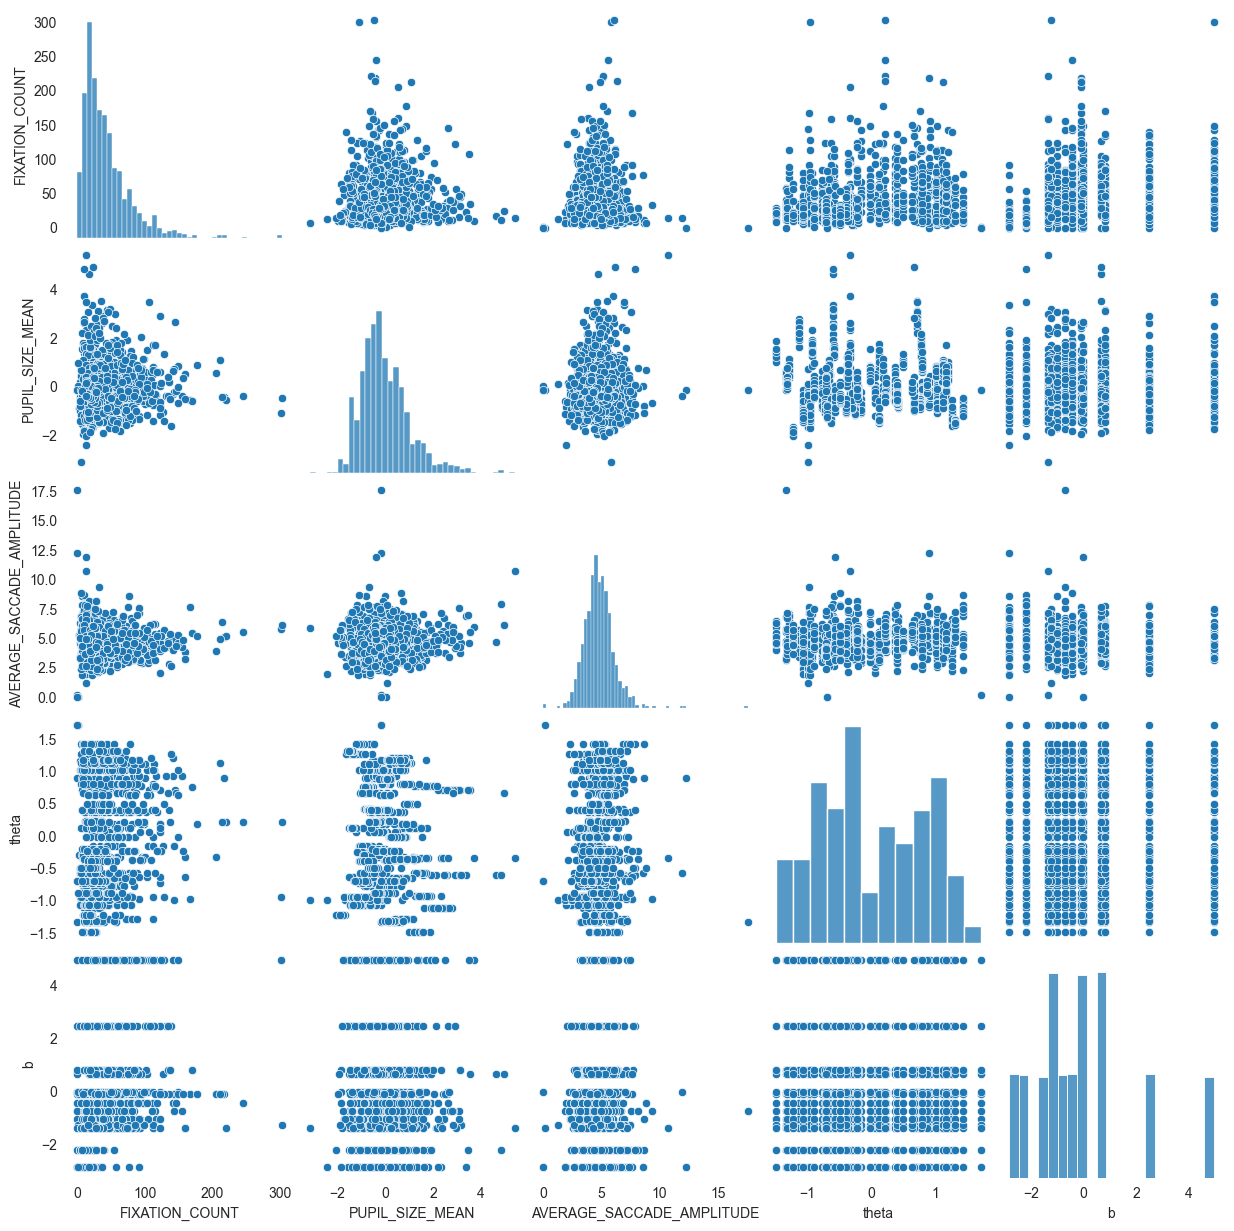

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
features = ['FIXATION_COUNT', 'PUPIL_SIZE_MEAN', 'AVERAGE_SACCADE_AMPLITUDE', 'theta']
sns.pairplot(merged_df[features + ['b']]) 
plt.show()


### This is a ML with 3 MAJOR eye tracking metrics

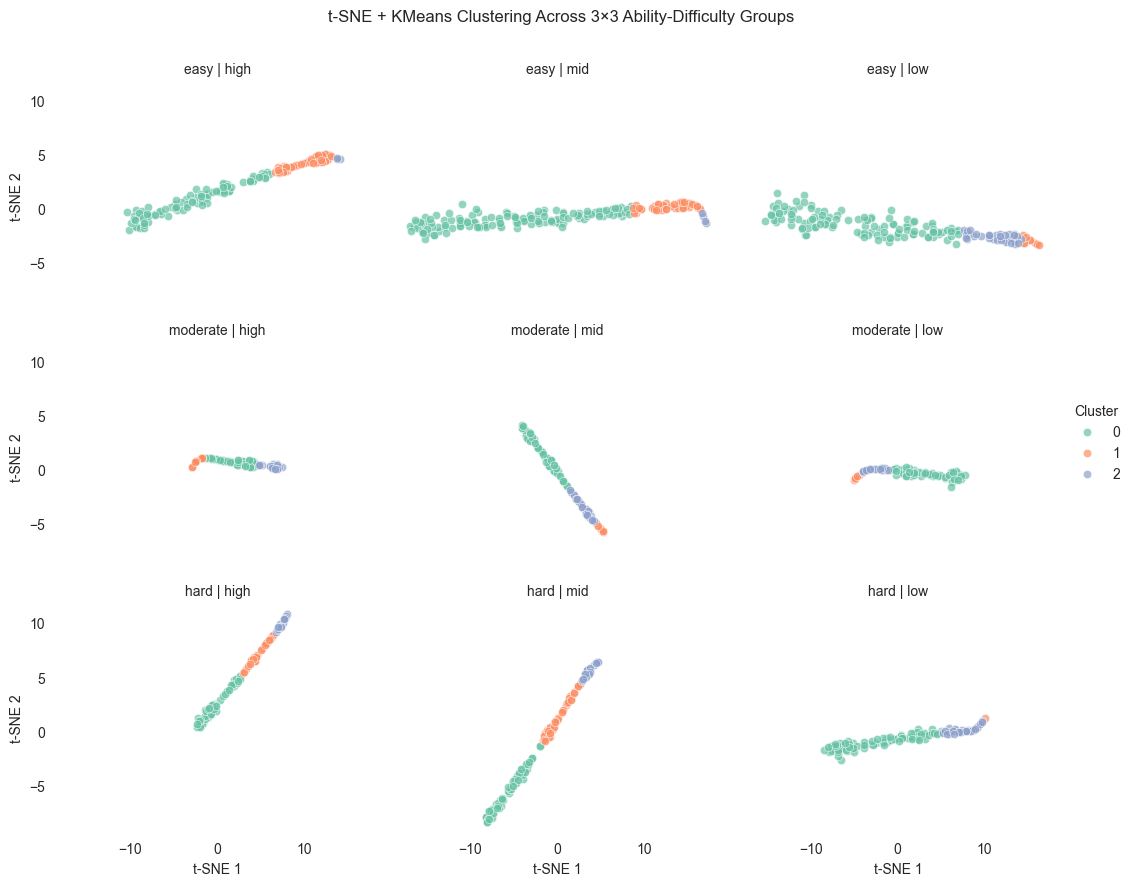

In [29]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define group labels
def ability_group(theta):
    if theta < -0.5:
        return 'low'
    elif theta > 0.5:
        return 'high'
    else:
        return 'mid'

def difficulty_group(b):
    if b < -0.5:
        return 'easy'
    elif b > 0.5:
        return 'hard'
    else:
        return 'moderate'

# Apply grouping
merged_df['ability_group'] = merged_df['theta'].apply(ability_group)
merged_df['difficulty_group'] = merged_df['b'].apply(difficulty_group)

# Add empty columns for t-SNE and Cluster
merged_df['tSNE1'] = None
merged_df['tSNE2'] = None
merged_df['Cluster'] = None

# Features to use for clustering
features = ['FIXATION_COUNT', 'PUPIL_SIZE_MEAN', 'AVERAGE_SACCADE_AMPLITUDE']

# Step 2: Loop over each ability × difficulty group
for ability in ['low', 'mid', 'high']:
    for difficulty in ['easy', 'moderate', 'hard']:
        mask = (merged_df['ability_group'] == ability) & (merged_df['difficulty_group'] == difficulty)
        subset = merged_df.loc[mask, features].dropna()

        if len(subset) < 5:  # Skip very small groups
            continue

        # Run t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_tsne = tsne.fit_transform(subset)
        
        # Run KMeans
        kmeans = KMeans(n_clusters=3, random_state=42)
        cluster_labels = kmeans.fit_predict(subset)
        
        # Get valid indices used for this subgroup
        valid_idx = merged_df.loc[mask].dropna(subset=features).index
        
        # Store results correctly
        merged_df.loc[valid_idx, 'tSNE1'] = X_tsne[:, 0]
        merged_df.loc[valid_idx, 'tSNE2'] = X_tsne[:, 1]
        merged_df.loc[valid_idx, 'Cluster'] = cluster_labels


# Convert Cluster to int for plotting (and drop missing rows)
plot_df = merged_df.dropna(subset=['tSNE1', 'tSNE2', 'Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)

# Step 3: Plot using FacetGrid
g = sns.FacetGrid(plot_df, col="ability_group", row="difficulty_group", hue="Cluster", palette="Set2", height=3, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="tSNE1", y="tSNE2", alpha=0.7)
g.add_legend(title="Cluster")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("t-SNE 1", "t-SNE 2")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("t-SNE + KMeans Clustering Across 3×3 Ability-Difficulty Groups")
plt.show()


### This is a ML with ALL eye tracking metrics

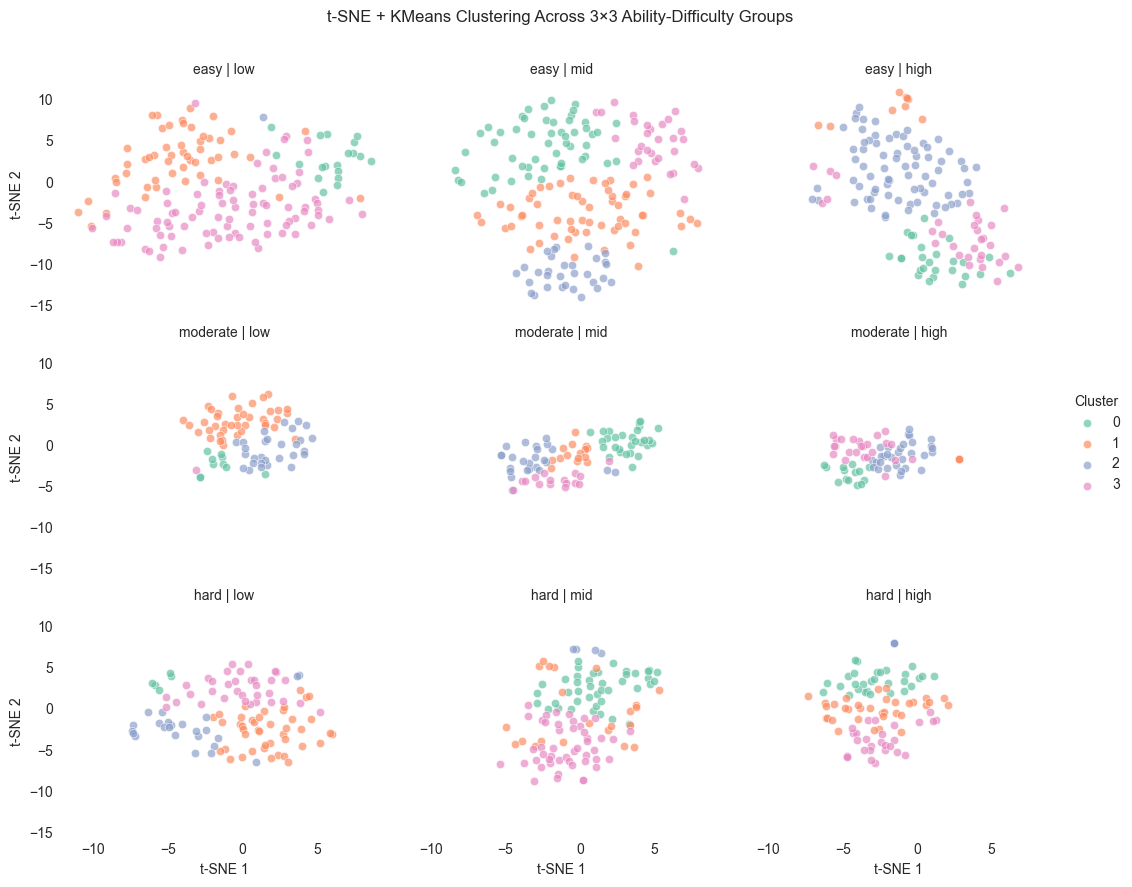

In [79]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define group labels
def ability_group(theta):
    if theta < -0.5:
        return 'low'
    elif theta > 0.5:
        return 'high'
    else:
        return 'mid'

def difficulty_group(b):
    if b < -0.5:
        return 'easy'
    elif b > 0.5:
        return 'hard'
    else:
        return 'moderate'

# Apply grouping
merged_df['ability_group'] = merged_df['theta'].apply(ability_group)
merged_df['difficulty_group'] = merged_df['b'].apply(difficulty_group)

# Add empty columns for t-SNE and Cluster
merged_df['tSNE1'] = None
merged_df['tSNE2'] = None
merged_df['Cluster'] = None

# Features to use for clustering
#features = ['FIXATION_COUNT', 'PUPIL_SIZE_MEAN', 'AVERAGE_SACCADE_AMPLITUDE']
# We used all eye tracking metrices
features = transformed_vars


# Step 2: Loop over each ability × difficulty group
for ability in ['low', 'mid', 'high']:
    for difficulty in ['easy', 'moderate', 'hard']:
        mask = (merged_df['ability_group'] == ability) & (merged_df['difficulty_group'] == difficulty)
        subset = merged_df.loc[mask, features].dropna()

        if len(subset) < 5:  # Skip very small groups
            continue

        # Run t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_tsne = tsne.fit_transform(subset)
        
        # Run KMeans
        kmeans = KMeans(n_clusters=4, random_state=42)
        cluster_labels = kmeans.fit_predict(subset)
        
        # Get valid indices used for this subgroup
        valid_idx = merged_df.loc[mask].dropna(subset=features).index
        
        # Store results correctly
        merged_df.loc[valid_idx, 'tSNE1'] = X_tsne[:, 0]
        merged_df.loc[valid_idx, 'tSNE2'] = X_tsne[:, 1]
        merged_df.loc[valid_idx, 'Cluster'] = cluster_labels


# Convert Cluster to int for plotting (and drop missing rows)
plot_df = merged_df.dropna(subset=['tSNE1', 'tSNE2', 'Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)
# Ensure correct order for plotting
plot_df['ability_group'] = pd.Categorical(
    plot_df['ability_group'], categories=['low', 'mid', 'high'], ordered=True
)

plot_df['difficulty_group'] = pd.Categorical(
    plot_df['difficulty_group'], categories=['easy', 'moderate', 'hard'], ordered=True
)



# Step 3: Plot using FacetGrid
g = sns.FacetGrid(plot_df, col="ability_group", row="difficulty_group", hue="Cluster", palette="Set2", height=3, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="tSNE1", y="tSNE2", alpha=0.7)
g.add_legend(title="Cluster")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("t-SNE 1", "t-SNE 2")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("t-SNE + KMeans Clustering Across 3×3 Ability-Difficulty Groups")
plt.show()


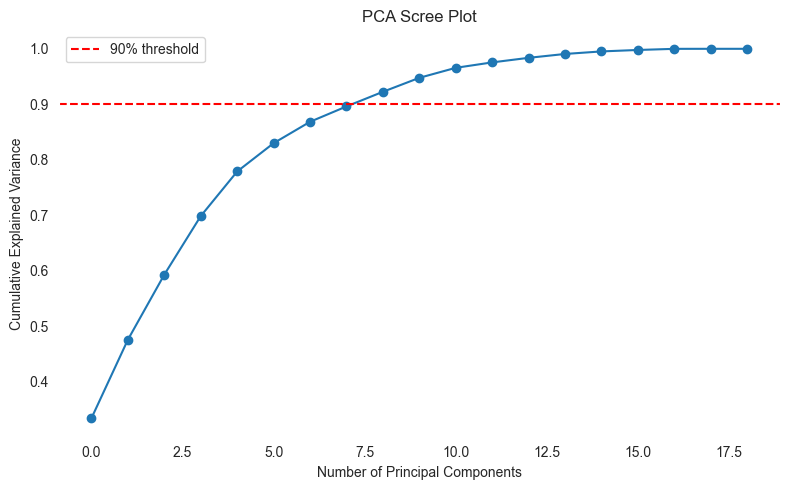

In [31]:
from sklearn.decomposition import PCA
import pandas as pd

# Prepare the data
X = merged_df[transformed_vars].dropna()

# Run PCA
pca = PCA(n_components=len(transformed_vars))
X_pca = pca.fit_transform(X)

# Put into DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.axhline(0.90, color='r', linestyle='--', label='90% threshold')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
loadings = pd.DataFrame(pca.components_.T, 
                        index=transformed_vars, 
                        columns=[f'PC{i+1}' for i in range(len(transformed_vars))])

# Show top contributing features to PC1 and PC2
loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False).head(10)


PC1       PC2
DURATION_log                   0.374004  0.006086
IP_DURATION_log                0.373929  0.005820
SACCADE_COUNT_log              0.368678 -0.158343
FIXATION_COUNT_log             0.361260 -0.156821
RUN_COUNT_log                  0.345337 -0.123095
FIXATION_DURATION_MAX_log      0.295599  0.298977
BLINK_COUNT_log                0.220594 -0.122126
SD_FIXATION_DURATION_log       0.211425  0.220842
AVERAGE_FIXATION_DURATION_log  0.164154  0.491184
SD_SACCADE_AMPLITUDE           0.104653 -0.215340

| Metric                          | PC1 (↑)   | PC2 (↑)   | Interpretation                                     |
| ------------------------------- | --------- | --------- | -------------------------------------------------- |
| `DURATION_log`                  | **0.374** | ≈ 0       | PC1 strongly reflects **total item viewing time**  |
| `IP_DURATION_log`               | **0.374** | ≈ 0       | …and **initial processing duration**               |
| `SACCADE_COUNT_log`             | **0.369** | −0.158    | …and **amount of visual scanning**                 |
| `FIXATION_COUNT_log`            | **0.361** | −0.157    | …and **attention density**                         |
| `RUN_COUNT_log`                 | **0.345** | −0.123    | …and **number of repeated visits to areas**        |
| `FIXATION_DURATION_MAX_log`     | 0.296     | 0.299     | PC2 reflects **peak fixation effort**              |
| `AVERAGE_FIXATION_DURATION_log` | 0.164     | **0.491** | PC2 emphasizes **average sustained attention**     |
| `SD_FIXATION_DURATION_log`      | 0.211     | 0.221     | Variation in fixation duration → **inconsistency** |


### This is a ML with 8 MAJOR eye tracking metrics from PCA Analysis

In [31]:
clusters

array([1, 1, 0, ..., 1, 1, 0], dtype=int32)

In [35]:
top_PC1_metrics = loadings['PC1'].sort_values(ascending=False).head(8).index.tolist()
#top_PC2_metrics = loadings['PC2'].sort_values(ascending=False).head(8).index.tolist()
print(top_PC1_metrics)
#print(top_PC2_metrics)

['DURATION_log', 'IP_DURATION_log', 'SACCADE_COUNT_log', 'FIXATION_COUNT_log', 'RUN_COUNT_log', 'FIXATION_DURATION_MAX_log', 'BLINK_COUNT_log', 'SD_FIXATION_DURATION_log']


k=2 → Silhouette Score: 0.238
k=3 → Silhouette Score: 0.188
k=4 → Silhouette Score: 0.138
k=5 → Silhouette Score: 0.137
k=6 → Silhouette Score: 0.136


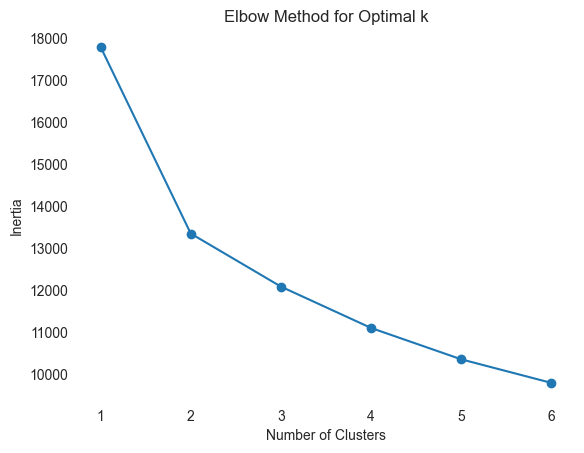

In [36]:
from sklearn.metrics import silhouette_score

# Try for k=2 to k=6
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca_8)  # or transformed_vars subset
    score = silhouette_score(X_pca_8, labels)
    print(f"k={k} → Silhouette Score: {score:.3f}")


inertias = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_8)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 7), inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


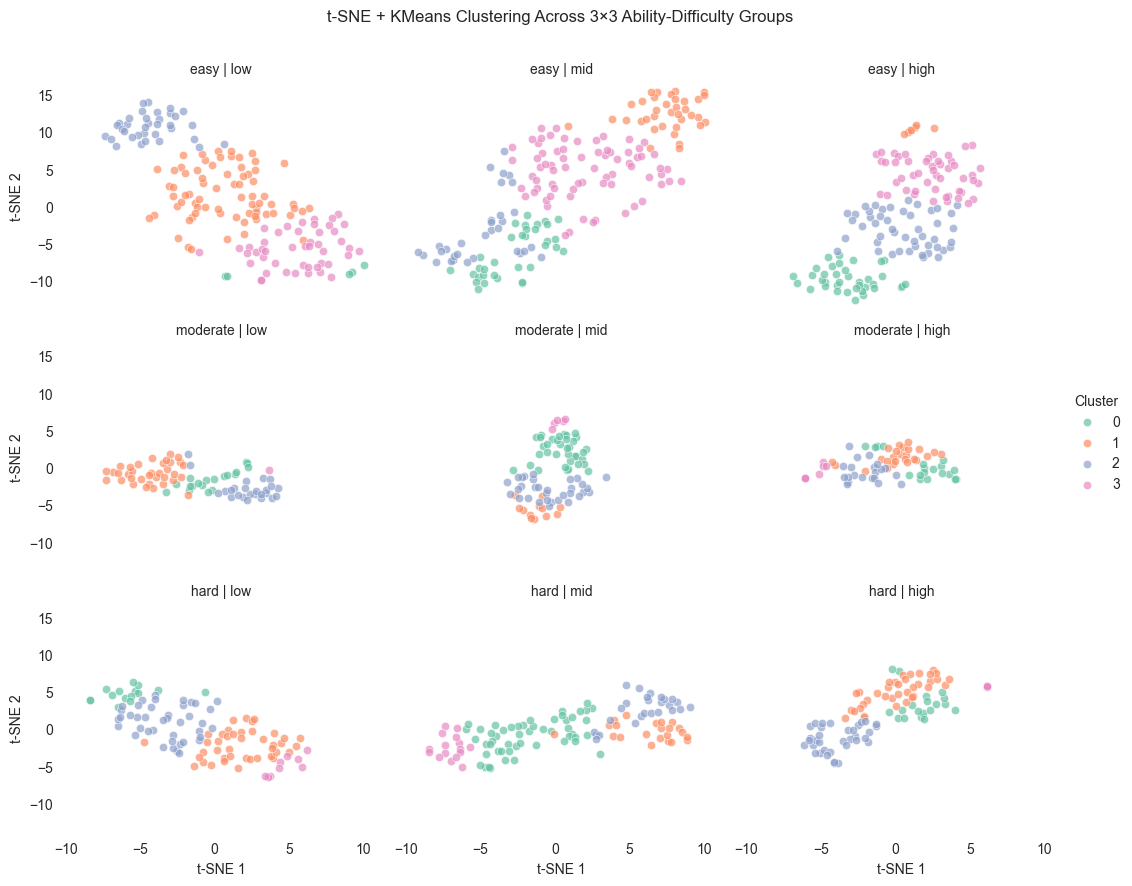

In [78]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define group labels
def ability_group(theta):
    if theta < -0.5:
        return 'low'
    elif theta > 0.5:
        return 'high'
    else:
        return 'mid'

def difficulty_group(b):
    if b < -0.5:
        return 'easy'
    elif b > 0.5:
        return 'hard'
    else:
        return 'moderate'

# Apply grouping
merged_df['ability_group'] = merged_df['theta'].apply(ability_group)
merged_df['difficulty_group'] = merged_df['b'].apply(difficulty_group)

# Add empty columns for t-SNE and Cluster
merged_df['tSNE1'] = None
merged_df['tSNE2'] = None
merged_df['Cluster'] = None

# Features to use for clustering
#features = ['FIXATION_COUNT', 'PUPIL_SIZE_MEAN', 'AVERAGE_SACCADE_AMPLITUDE']
# We used top 10 pca metrics
features = top_PC1_metrics


# Step 2: Loop over each ability × difficulty group
for ability in ['low', 'mid', 'high']:
    for difficulty in ['easy', 'moderate', 'hard']:
        mask = (merged_df['ability_group'] == ability) & (merged_df['difficulty_group'] == difficulty)
        subset = merged_df.loc[mask, features].dropna()

        if len(subset) < 5:  # Skip very small groups
            continue

        # Run t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_tsne = tsne.fit_transform(subset)
        
        # Run KMeans
        kmeans = KMeans(n_clusters=4, random_state=42)
        cluster_labels = kmeans.fit_predict(subset)
        
        # Get valid indices used for this subgroup
        valid_idx = merged_df.loc[mask].dropna(subset=features).index
        
        # Store results correctly
        merged_df.loc[valid_idx, 'tSNE1'] = X_tsne[:, 0]
        merged_df.loc[valid_idx, 'tSNE2'] = X_tsne[:, 1]
        merged_df.loc[valid_idx, 'Cluster'] = cluster_labels


# Convert Cluster to int for plotting (and drop missing rows)
plot_df = merged_df.dropna(subset=['tSNE1', 'tSNE2', 'Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)
# Ensure correct order for plotting
plot_df['ability_group'] = pd.Categorical(
    plot_df['ability_group'], categories=['low', 'mid', 'high'], ordered=True
)

plot_df['difficulty_group'] = pd.Categorical(
    plot_df['difficulty_group'], categories=['easy', 'moderate', 'hard'], ordered=True
)

# Step 3: Plot using FacetGrid
g = sns.FacetGrid(plot_df, col="ability_group", row="difficulty_group", hue="Cluster", palette="Set2", height=3, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="tSNE1", y="tSNE2", alpha=0.7)
g.add_legend(title="Cluster")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("t-SNE 1", "t-SNE 2")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("t-SNE + KMeans Clustering Across 3×3 Ability-Difficulty Groups")
plt.show()


In [80]:
# Make sure Cluster is int
merged_df['Cluster'] = merged_df['Cluster'].astype('Int64')

# Select only rows with all necessary values
cluster_data = merged_df.dropna(subset=transformed_vars + ['Cluster'])

# Group by cluster and compute means
cluster_profile = cluster_data.groupby('Cluster')[transformed_vars].mean().round(2)

# Optional: add sample size per cluster
cluster_profile['N'] = cluster_data['Cluster'].value_counts().sort_index()

# View the profile table
import pandas as pd
pd.set_option("display.max_columns", 100)  # show all columns
display(cluster_profile)


AVERAGE_FIXATION_DURATION_log  FIXATION_COUNT_log  \
Cluster                                                      
0                                -0.29               -0.24   
1                                 0.17                0.11   
2                                 0.01               -0.11   
3                                 0.26                0.22   

         FIXATION_DURATION_MAX_log  FIXATION_DURATION_MIN_log  \
Cluster                                                         
0                            -0.37                       0.00   
1                             0.21                      -0.10   
2                            -0.04                       0.07   
3                             0.28                       0.14   

         MEDIAN_FIXATION_DURATION_log  SD_FIXATION_DURATION_log  \
Cluster                                                           
0                               -0.21                     -0.24   
1                                0.13                      0.11   
2                                0.00                      0.02   
3                                0.23                      0.21   

         AVERAGE_SACCADE_AMPLITUDE_sqrt  MEDIAN_SACCADE_AMPLITUDE_sqrt  \
Cluster                                                                  
0                                  0.15                           0.23   
1                                 -0.09                          -0.24   
2                                  0.13                           0.07   
3                                 -0.12                          -0.06   

         SACCADE_COUNT_log  SD_SACCADE_AMPLITUDE  PUPIL_SIZE_MEAN  \
Cluster                                                             
0                    -0.26                  0.13            -0.06   
1                     0.13                  0.05             0.17   
2                    -0.11                  0.02             0.15   
3                     0.22                 -0.09            -0.23   

         PUPIL_SIZE_MAX_log  PUPIL_SIZE_MIN  AVERAGE_BLINK_DURATION_log  \
Cluster                                                                   
0                     -0.04            0.01                        0.09   
1                      0.29            0.02                        0.17   
2                      0.03            0.22                       -0.05   
3                     -0.26           -0.18                       -0.19   

         BLINK_COUNT_log  RUN_COUNT_log  \
Cluster                                   
0                  -0.11          -0.30   
1                   0.22           0.05   
2                  -0.05          -0.03   
3                  -0.03           0.24   

         VISITED_INTEREST_AREA_COUNT_reflectlog  DURATION_log  \
Cluster                                                         
0                                          0.26         -0.35   
1                                         -0.14          0.25   
2                                         -0.03         -0.10   
3                                         -0.10          0.23   

         IP_DURATION_log    N  
Cluster                        
0                  -0.35  228  
1                   0.25  276  
2                  -0.10  224  
3                   0.23  300

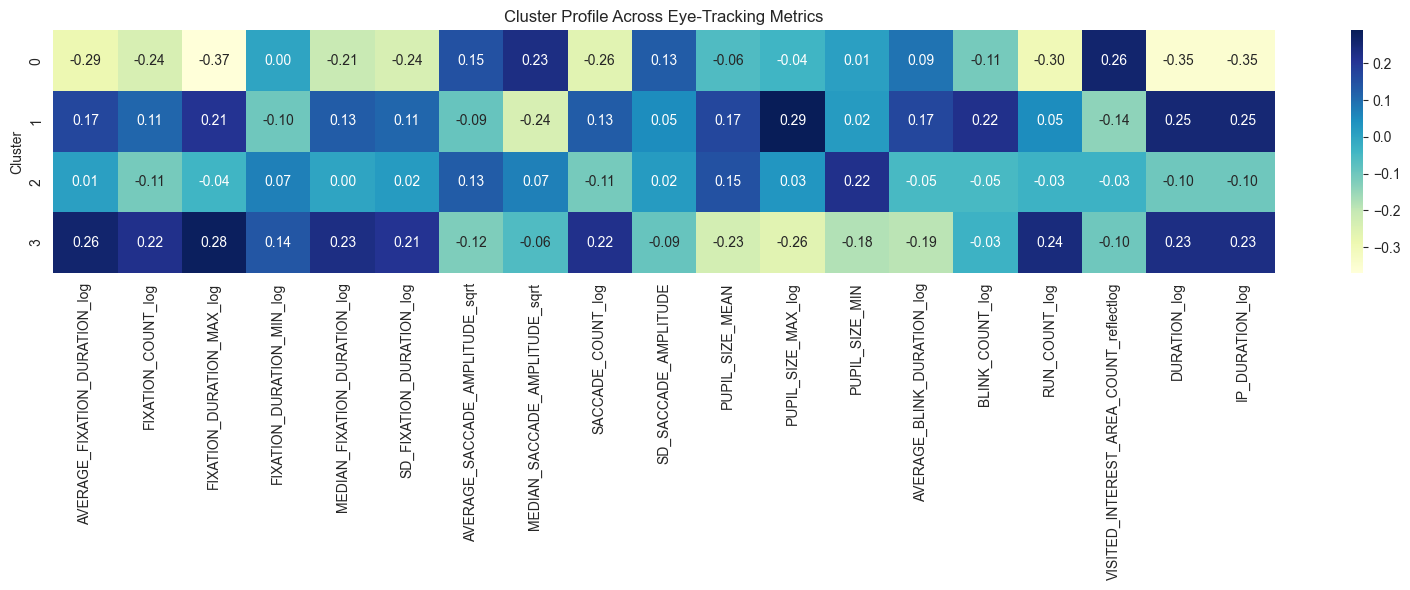

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(16, 6))  # You can increase width (e.g., 16 or 18)

# Exclude 'N' column from heatmap
sns.heatmap(
    cluster_profile.drop(columns='N'),
    cmap="YlGnBu",
    annot=True,
    fmt=".2f"
)

plt.title("Cluster Profile Across Eye-Tracking Metrics")
plt.tight_layout()
plt.show()


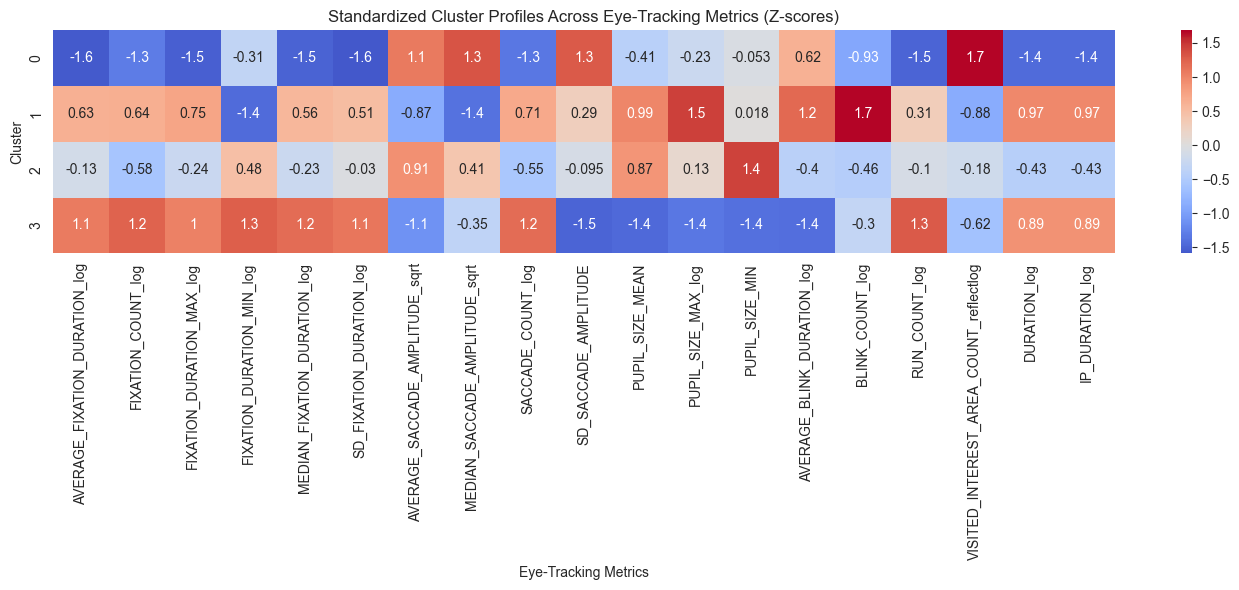

In [82]:
cluster_profile = cluster_data.groupby('Cluster')[transformed_vars].mean().round(2)

from sklearn.preprocessing import StandardScaler

# Standardize across clusters (rows)
scaler = StandardScaler()
cluster_profile_std = pd.DataFrame(
    scaler.fit_transform(cluster_profile[transformed_vars]),
    columns=transformed_vars,
    index=cluster_profile.index
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_profile_std, annot=True, cmap="coolwarm", center=0)
plt.title("Standardized Cluster Profiles Across Eye-Tracking Metrics (Z-scores)")
plt.xlabel("Eye-Tracking Metrics")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


✅ Accuracy by Ability × Difficulty × Cluster:
   ability_group difficulty_group  Cluster  count   mean
0           high             easy        0     69  0.942
1           high             easy        1     72  0.972
2           high             hard        0     48  0.521
3           high             hard        1     47  0.362
4           high         moderate        0     55  0.891
5           high         moderate        1     17  0.824
6            low             easy        0     98  0.622
7            low             easy        1     61  0.525
8            low             hard        0     47  0.234
9            low             hard        1     59  0.169
10           low         moderate        0     34  0.265
11           low         moderate        1     46  0.261
12           mid             easy        0     96  0.865
13           mid             easy        1     78  0.718
14           mid             hard        0     49  0.327
15           mid             hard        1

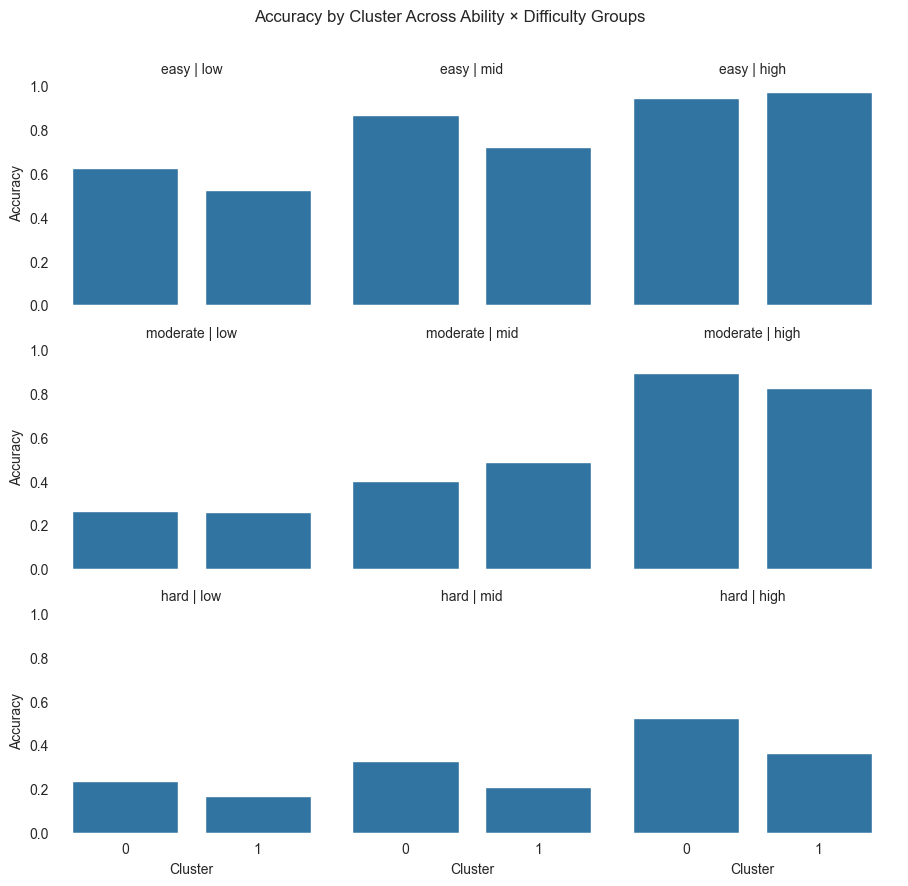

In [42]:
accuracy_detailed = (
    merged_df.dropna(subset=['Cluster', 'response'])
    .groupby(['ability_group', 'difficulty_group', 'Cluster'])['response']
    .agg(count='count', mean='mean')
    .round(3)
    .reset_index()
)

print("✅ Accuracy by Ability × Difficulty × Cluster:")
print(accuracy_detailed)




g = sns.catplot(
    data=accuracy_detailed,
    x='Cluster', y='mean',
    col='ability_group', row='difficulty_group',
    kind='bar', height=3, aspect=1,
    col_order=['low', 'mid', 'high'],
    row_order=['easy', 'moderate', 'hard']
)

g.set_axis_labels("Cluster", "Accuracy")
g.set_titles("{row_name} | {col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Accuracy by Cluster Across Ability × Difficulty Groups")
plt.show()



#### Count Participants per Cluster per Item

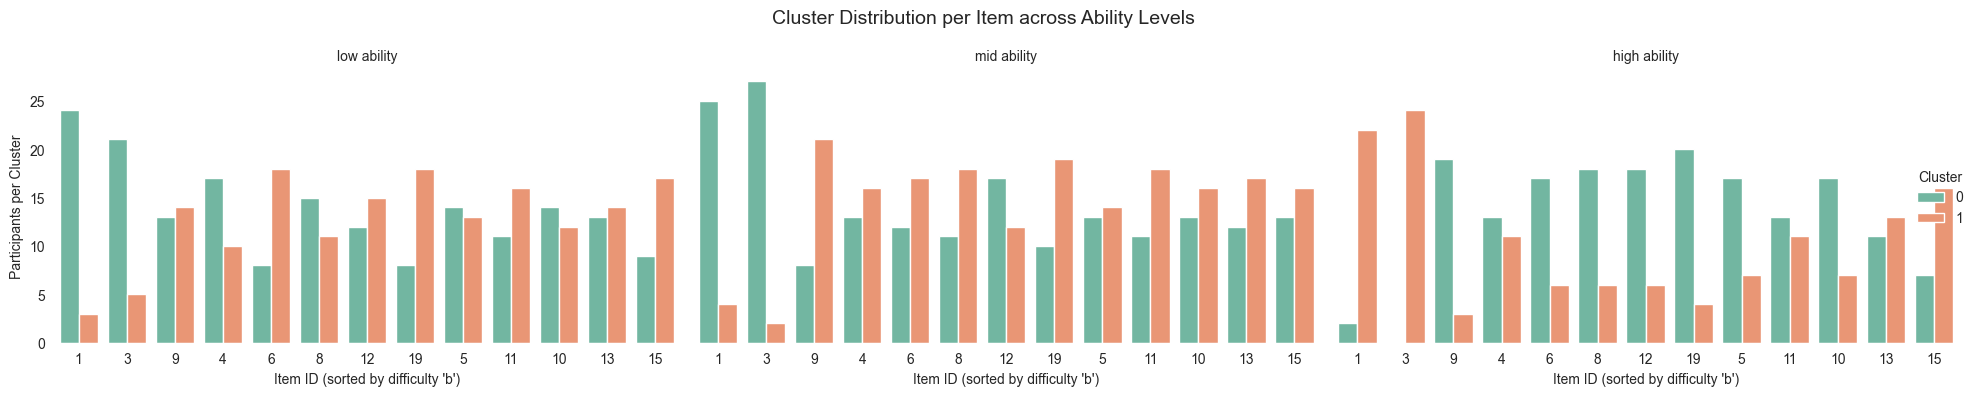

In [44]:
# Step 1: Prepare long-format DataFrame for plotting
records = []

for ability in ['low', 'mid', 'high']:
    subset_df = merged_df[merged_df['ability_group'] == ability]
    
    # Count per item-cluster
    cluster_counts = (
        subset_df.dropna(subset=['Cluster'])
        .groupby(['trialid', 'Cluster'])
        .size()
        .reset_index(name='count')
    )
    cluster_counts['ability_group'] = ability

    # Merge difficulty info
    difficulty = subset_df[['trialid', 'b']].drop_duplicates()
    cluster_counts = cluster_counts.merge(difficulty, on='trialid', how='left')
    
    records.append(cluster_counts)

# Combine all ability groups
plot_df = pd.concat(records)

# Step 2: Sort trialid by mean difficulty (for consistent x-axis)
trialid_order = plot_df.groupby('trialid')['b'].mean().sort_values().index.tolist()
plot_df['trialid'] = pd.Categorical(plot_df['trialid'], categories=trialid_order, ordered=True)

# Step 3: Plot using catplot
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=plot_df, kind="bar",
    x="trialid", y="count", hue="Cluster",
    col="ability_group", col_order=["low", "mid", "high"],
    palette="Set2", height=4, aspect=1.6, sharey=True
)

g.set_titles("{col_name} ability")
g.set_axis_labels("Item ID (sorted by difficulty 'b')", "Participants per Cluster")
g.set_xticklabels(rotation=0)
g._legend.set_title("Cluster")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Cluster Distribution per Item across Ability Levels", fontsize=14)
plt.tight_layout()
plt.show()


### Unsupervised Anomaly Detection

In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Step 1: PCA (optional but recommended)
X = merged_df[features].dropna()
X_pca = PCA(n_components=8).fit_transform(X)

# Step 2: Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_flags = iso.fit_predict(X_pca)

# Step 3: Mark outliers
merged_df.loc[X.index, 'is_outlier'] = (outlier_flags == -1)
filtered_df = merged_df[merged_df['is_outlier'] == False]


In [49]:
features

['DURATION_log',
 'IP_DURATION_log',
 'SACCADE_COUNT_log',
 'FIXATION_COUNT_log',
 'RUN_COUNT_log',
 'FIXATION_DURATION_MAX_log',
 'BLINK_COUNT_log',
 'SD_FIXATION_DURATION_log']

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

# ------------------------------
# Step 1: PCA before IsolationForest
# ------------------------------
pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(merged_df[features])  # features = your eye-tracking metric names

# ------------------------------
# Step 2: Outlier detection
# ------------------------------
merged_df = merged_df.copy()
merged_df['is_outlier'] = IsolationForest(contamination=0.05, random_state=42).fit_predict(X_pca) == -1

# ------------------------------
# Step 3: Run t-SNE before and after outlier removal
# ------------------------------
# t-SNE on full data
tsne_full = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
X_tsne_full = tsne_full.fit_transform(X_pca)

# t-SNE on inliers only
X_inliers = X_pca[~merged_df['is_outlier']]
tsne_clean = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
X_tsne_clean = tsne_clean.fit_transform(X_inliers)

# ------------------------------
# Step 4: Prepare DataFrames for Plotting
# ------------------------------
df_full = pd.DataFrame(X_tsne_full, columns=['tSNE1', 'tSNE2'])
df_full['Outlier'] = merged_df['is_outlier'].map({True: 'Outlier', False: 'Inlier'})

df_clean = pd.DataFrame(X_tsne_clean, columns=['tSNE1', 'tSNE2'])
df_clean['Outlier'] = 'Inlier only'

# ------------------------------
# Step 5: Plot Comparison
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot before outlier removal
sns.scatterplot(data=df_full, x='tSNE1', y='tSNE2', hue='Outlier', palette='Set2', alpha=0.7, ax=axes[0])
axes[0].set_title("t-SNE Before Outlier Removal")

# Plot after outlier removal
sns.scatterplot(data=df_clean, x='tSNE1', y='tSNE2', color='blue', alpha=0.7, ax=axes[1])
axes[1].set_title("t-SNE After Outlier Removal")

for ax in axes:
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.suptitle("Visual Comparison of t-SNE Before vs After Outlier Removal")
plt.tight_layout()
plt.show()


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [50]:
merged_df

RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                   ET24_066        4         1                     366.88   
1                   ET24_066       12         1                     354.98   
2                   ET24_066        1         1                        NaN   
4                   ET24_066        6         1                     206.57   
6                   ET24_066        3         1                     243.31   
...                      ...      ...       ...                        ...   
1573                ET22027B       15         0                     244.70   
1574                ET22027B        9         1                     317.89   
1577                ET22027B        5         0                     331.28   
1580                ET22027B        6         1                     249.12   
1581                ET22027B        1         1                    2530.00   

      FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0                 57                 1011.0                   90.0   
1                 57                 1134.0                   36.0   
2                  0                    NaN                    NaN   
4                  7                  416.0                    8.0   
6                 16                  749.0                   82.0   
...              ...                    ...                    ...   
1573              27                  864.0                   36.0   
1574              28                  680.0                  120.0   
1577              50                 1252.0                   32.0   
1580              66                  972.0                   28.0   
1581               1                 2530.0                 2530.0   

      MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  \
0                        368.0                198.33   
1                        308.0                206.06   
2                          NaN                   NaN   
4                        234.0                142.05   
6                        207.0                153.36   
...                        ...                   ...   
1573                     184.0                221.73   
1574                     312.0                137.31   
1577                     242.0                273.69   
1580                     196.0                200.88   
1581                    2530.0                  0.00   

      AVERAGE_SACCADE_AMPLITUDE  ...  IP_DURATION_log     theta         a  \
0                          5.45  ...         0.849676  0.901464  1.005008   
1                          5.54  ...         0.844893  0.901464  0.237844   
2                         12.28  ...        -0.841571  0.901464  2.152613   
4                          8.63  ...         0.471855  0.901464  1.191527   
6                          5.89  ...        -1.028059  0.901464  1.350515   
...                         ...  ...              ...       ...       ...   
1573                       7.46  ...         1.135270 -0.886110  0.312253   
1574                       4.31  ...        -0.190524 -0.886110  0.362378   
1577                       5.65  ...         0.572616 -0.886110  2.187539   
1580                       5.48  ...         0.897347 -0.886110  1.191527   
1581                        NaN  ...        -1.816449 -0.886110  2.152613   

             b  ability_group  difficulty_group      tSNE1      tSNE2  \
0    -1.242181           high              easy  -1.861774   -9.71644   
1    -0.427681           high          moderate   0.301532   1.856484   
2    -2.851688           high              easy   0.986336  10.198791   
4    -1.013916           high              easy   5.161428    8.23013   
6    -2.184618           high              easy   2.514813   0.705008   
...        ...            ...               ...        ...        ...   
1573  4.967737            low              hard   3.948766  -0.576042   
1574 -1.364356            low              ea

🔍 Cluster Composition by Ability × Difficulty
difficulty_group       easy  hard  moderate
Cluster ability_group                      
0       high             22     4         3
        low              25     6        14
        mid              19     6         2
1       high             46    60        55
        low              32    49        34
        mid              53    70        55
2       high             54    15         9
        low              62    30        20
        mid              76    26        19
3       high             19    16         5
        low              40    21        12
        mid              26    14         9


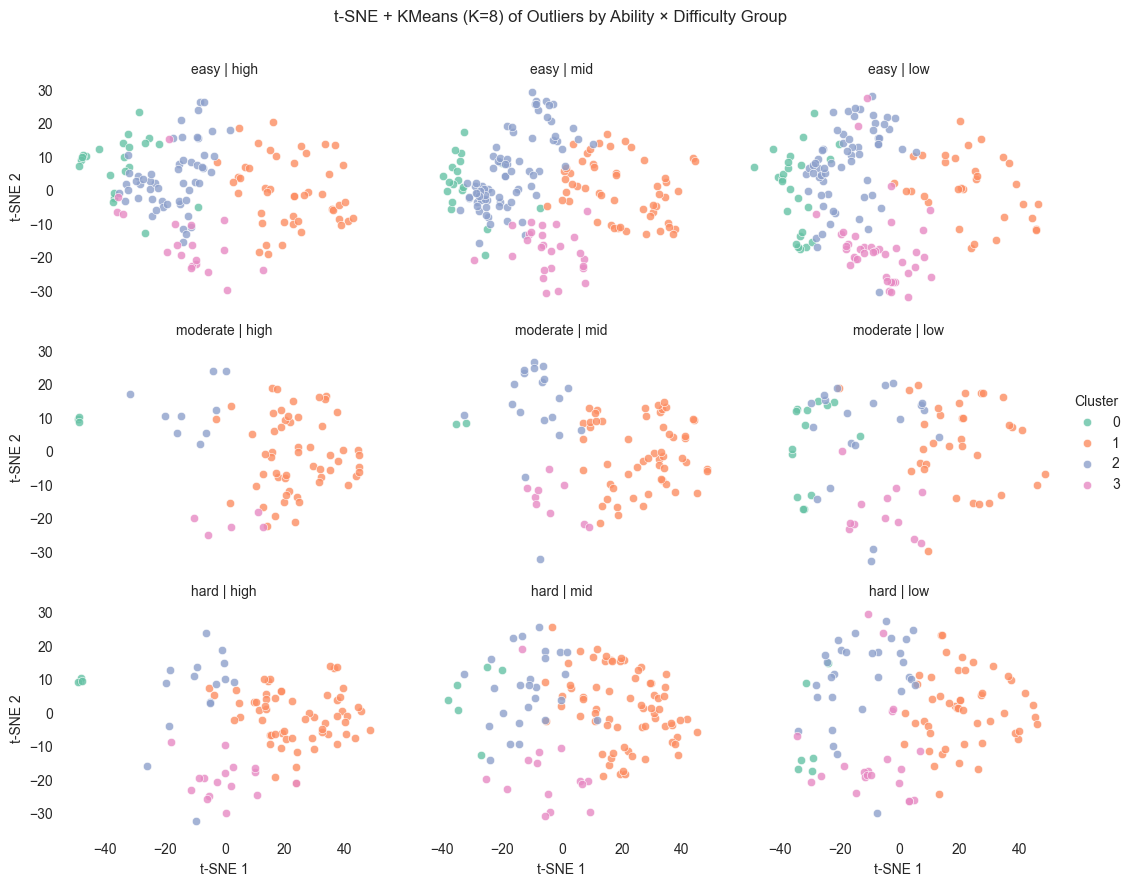

In [70]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Choose whether to analyze only outliers or the full dataset
use_outliers_only = False  # ✅ Analyze outliers only

# Step 1: Feature selection
features = transformed_vars  # your log-transformed eye-tracking metrics

# Step 2: Filter data
if use_outliers_only:
    data = merged_df[merged_df['is_outlier'] == False].dropna(subset=features).copy()
else:
    data = merged_df.dropna(subset=features).copy()

# Step 3: Check data size
if data.shape[0] < 5:
    raise ValueError("Too few data points for t-SNE and KMeans.")

# Step 4: t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(data[features])

# ✅ Step 5: KMeans clustering with K=8
kmeans = KMeans(n_clusters=4, random_state=42)  # increase K here

# Reattach contextual labels
data['ability_group'] = merged_df.loc[data.index, 'ability_group']
data['difficulty_group'] = merged_df.loc[data.index, 'difficulty_group']


data['Cluster'] = kmeans.fit_predict(data[features])
data['tSNE1'] = X_tsne[:, 0]
data['tSNE2'] = X_tsne[:, 1]

# Summarize cluster composition by ability and difficulty
summary = (
    data.groupby(['Cluster', 'ability_group', 'difficulty_group'])
    .size()
    .unstack(fill_value=0)
)
print("🔍 Cluster Composition by Ability × Difficulty")
print(summary)


# Step 6: Plot
g = sns.FacetGrid(data, col="ability_group", row="difficulty_group", hue="Cluster", palette="Set2", height=3, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="tSNE1", y="tSNE2", alpha=0.8)
g.add_legend(title="Cluster")
g.set_titles("{row_name} | {col_name}")
g.set_axis_labels("t-SNE 1", "t-SNE 2")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("t-SNE + KMeans (K=8) of Outliers by Ability × Difficulty Group")
plt.show()



📊 Mean Eye-Tracking Metrics per Cluster (Outliers Only):


AVERAGE_FIXATION_DURATION_log  FIXATION_COUNT_log  \
Cluster                                                      
0                               -0.371              -1.695   
1                                0.435               0.806   
2                               -0.132              -0.501   
3                               -0.362              -0.134   

         FIXATION_DURATION_MAX_log  FIXATION_DURATION_MIN_log  \
Cluster                                                         
0                           -0.806                      0.465   
1                            0.738                     -0.170   
2                           -0.459                      0.242   
3                           -0.380                     -0.093   

         MEDIAN_FIXATION_DURATION_log  SD_FIXATION_DURATION_log  \
Cluster                                                           
0                              -0.282                    -0.698   
1                               0.274                     0.507   
2                               0.020                    -0.242   
3                              -0.282                    -0.262   

         AVERAGE_SACCADE_AMPLITUDE_sqrt  MEDIAN_SACCADE_AMPLITUDE_sqrt  \
Cluster                                                                  
0                                -0.806                         -0.416   
1                                -0.136                         -0.318   
2                                 0.333                          0.479   
3                                 0.279                          0.142   

         SACCADE_COUNT_log  SD_SACCADE_AMPLITUDE  PUPIL_SIZE_MEAN  \
Cluster                                                             
0                   -1.672                -1.219           -0.442   
1                    0.830                 0.106           -0.128   
2                   -0.539                 0.094           -0.452   
3                   -0.147                 0.417            1.483   

         PUPIL_SIZE_MAX_log  PUPIL_SIZE_MIN  AVERAGE_BLINK_DURATION_log  \
Cluster                                                                   
0                    -0.465          -0.061                       0.834   
1                     0.016          -0.388                      -0.089   
2                    -0.575          -0.021                      -0.199   
3                     1.354           1.199                       0.111   

         BLINK_COUNT_log  RUN_COUNT_log  \
Cluster                                   
0                 -0.437         -1.898   
1                  0.571          0.745   
2                 -0.597         -0.355   
3                 -0.077         -0.172   

         VISITED_INTEREST_AREA_COUNT_reflectlog  DURATION_log  IP_DURATION_log  
Cluster                                                                         
0                                         1.769        -1.252           -1.259  
1                                        -0.546         0.906            0.904  
2                                         0.142        -0.669           -0.667  
3                                         0.063        -0.251           -0.248

C:\Users\julia\AppData\Local\Temp\ipykernel_26392\147774737.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\julia\OneDrive - The University of Alabama\Research\202506-ML-EyeTracking\notebooks\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


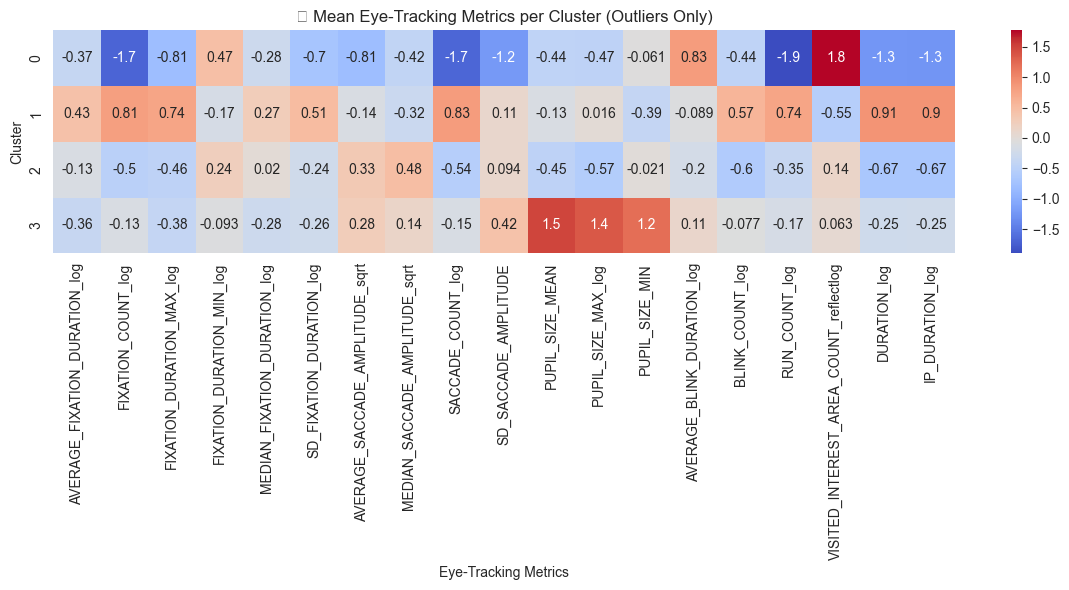

In [71]:
# Calculate mean of all metrics used for clustering per cluster
cluster_means = (
    data.groupby('Cluster')[features]
    .mean()
    .round(3)
)

print("📊 Mean Eye-Tracking Metrics per Cluster (Outliers Only):")
display(cluster_means)



plt.figure(figsize=(12, 6))  # Adjust width and height as needed
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', cbar=True)

plt.title("📊 Mean Eye-Tracking Metrics per Cluster (Outliers Only)")
plt.xlabel("Eye-Tracking Metrics")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


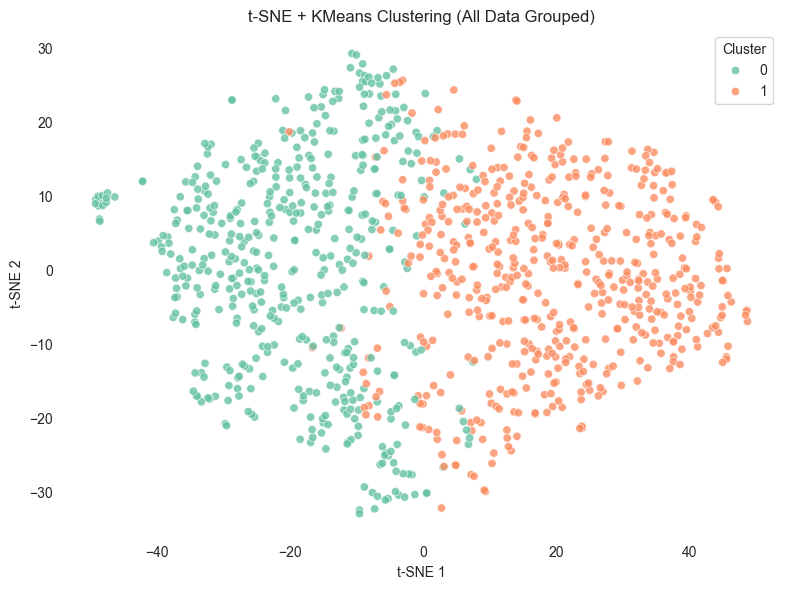

In [49]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Use only outliers or the full dataset
use_outliers_only = False  # set to True to filter for outliers only

# Features used for clustering
features = transformed_vars  # e.g., list of log-transformed eye-tracking metrics

# Filter data
if use_outliers_only:
    data = merged_df[merged_df['is_outlier'] == False].dropna(subset=features).copy()
else:
    data = merged_df.dropna(subset=features).copy()

# Check data size
if data.shape[0] < 5:
    raise ValueError("Too few data points for t-SNE and KMeans.")

# Step 1: t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(data[features])

# Step 2: KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[features])
data['tSNE1'] = X_tsne[:, 0]
data['tSNE2'] = X_tsne[:, 1]

# Step 3: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='tSNE1', y='tSNE2', hue='Cluster', palette='Set2', alpha=0.8)
plt.title("t-SNE + KMeans Clustering (All Data{} Grouped)".format(" - Outliers Only" if use_outliers_only else ""))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


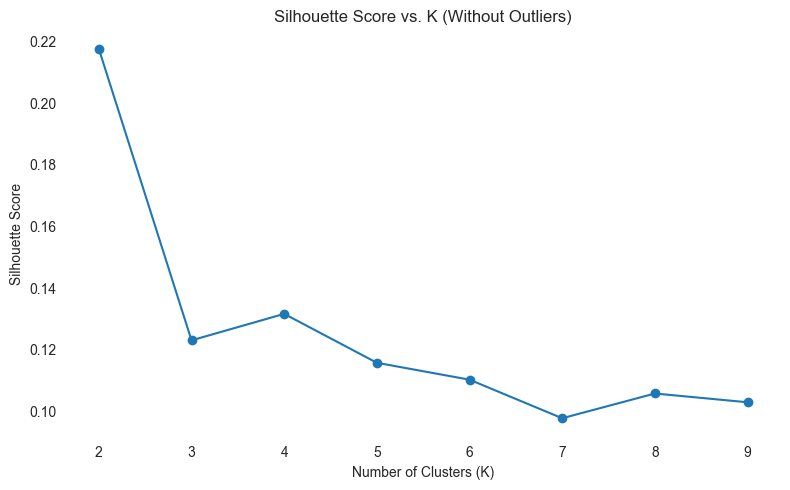

In [50]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 1: Filter out outliers
# ------------------------------
features = transformed_vars  # list of eye-tracking features
filtered_df = merged_df[merged_df['is_outlier'] == False].dropna(subset=features).copy()

# ------------------------------
# Step 2: Loop to compute Silhouette Scores
# ------------------------------
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(filtered_df[features])
    score = silhouette_score(filtered_df[features], labels)
    silhouette_scores.append(score)

# ------------------------------
# Step 3: Plot the silhouette scores
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. K (Without Outliers)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


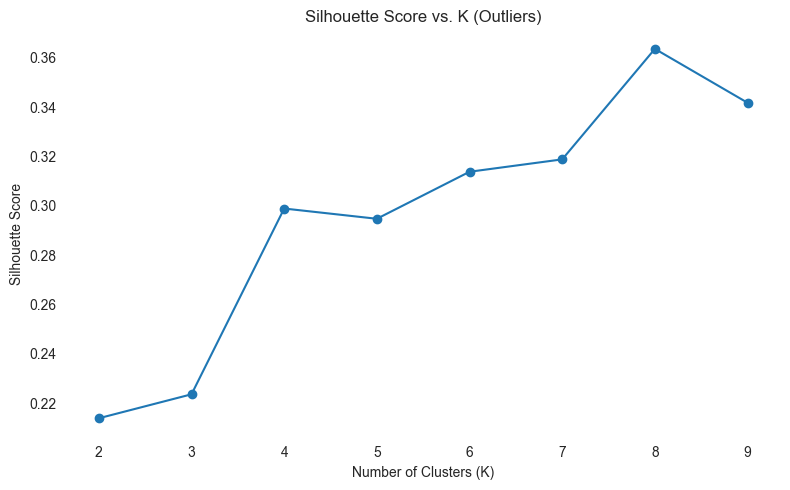

In [51]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 1: Filter out outliers
# ------------------------------
features = transformed_vars  # list of eye-tracking features
filtered_df = merged_df[merged_df['is_outlier'] == True].dropna(subset=features).copy()

# ------------------------------
# Step 2: Loop to compute Silhouette Scores
# ------------------------------
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(filtered_df[features])
    score = silhouette_score(filtered_df[features], labels)
    silhouette_scores.append(score)

# ------------------------------
# Step 3: Plot the silhouette scores
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. K (Outliers)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


### Engagement

In [52]:
merged_df['Engagement_Score'] = merged_df[[
    'FIXATION_COUNT_log',
    'AVERAGE_FIXATION_DURATION_log',
    'PUPIL_SIZE_MEAN',
    'RUN_COUNT_log',
    'DURATION_log'
]].apply(lambda x: (x - x.mean())/x.std()).mean(axis=1)

low_engagement = merged_df['Engagement_Score'].quantile(0.1)
merged_df['Low_Engagement_Flag'] = merged_df['Engagement_Score'] < low_engagement


### Detect Guessers (Low fixation, fast responding, low accuracy)

In [53]:
merged_df['Guessing_Score'] = merged_df[['FIXATION_COUNT_log', 'DURATION_log', 'response']].apply(
    lambda row: (row['FIXATION_COUNT_log'] + row['DURATION_log']) / 2 if row['response'] == 0 else np.nan, axis=1)

guessing_threshold = merged_df['Guessing_Score'].quantile(0.1)
merged_df['Guessing_Flag'] = merged_df['Guessing_Score'] < guessing_threshold


### Potential Cheating Detection (High accuracy, abnormal eye movement)

In [54]:
merged_df['EyeMovement_Score'] = merged_df[['AVERAGE_SACCADE_AMPLITUDE_sqrt', 'BLINK_COUNT_log']].apply(
    lambda x: (x - x.mean())/x.std()).mean(axis=1)

high_accuracy = merged_df['response'] == 1
abnormal_eye_movement = merged_df['EyeMovement_Score'].quantile(0.9)

merged_df['Cheating_Flag'] = (high_accuracy) & (merged_df['EyeMovement_Score'] > abnormal_eye_movement)


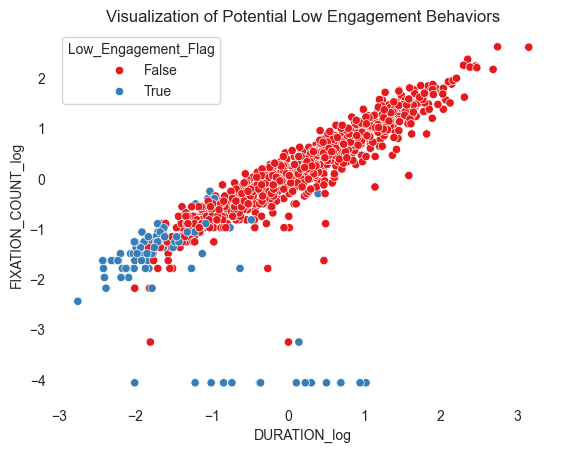

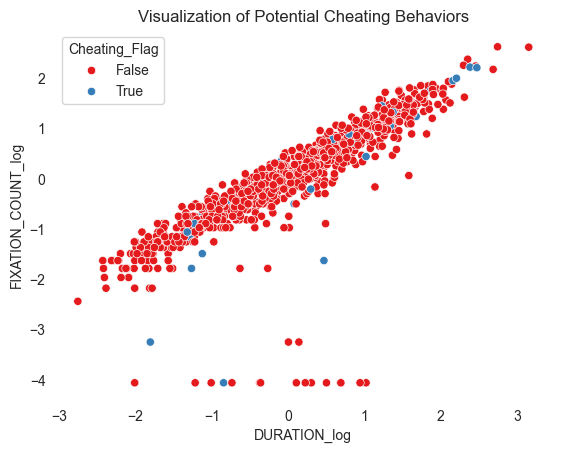

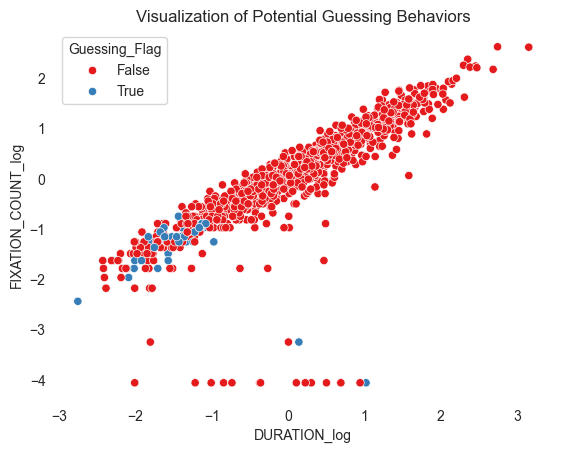

In [55]:
sns.scatterplot(data=merged_df, x='DURATION_log', y='FIXATION_COUNT_log',
                hue='Low_Engagement_Flag',
                palette='Set1')
plt.title("Visualization of Potential Low Engagement Behaviors")
plt.show()


sns.scatterplot(data=merged_df, x='DURATION_log', y='FIXATION_COUNT_log',
                hue='Cheating_Flag',
                palette='Set1')
plt.title("Visualization of Potential Cheating Behaviors")
plt.show()

sns.scatterplot(data=merged_df, x='DURATION_log', y='FIXATION_COUNT_log',
                hue='Guessing_Flag',
                palette='Set1')
plt.title("Visualization of Potential Guessing Behaviors")
plt.show()


###  UMAP Visualization

### DBSCAN

Silhouette Score (DBSCAN): 0.35


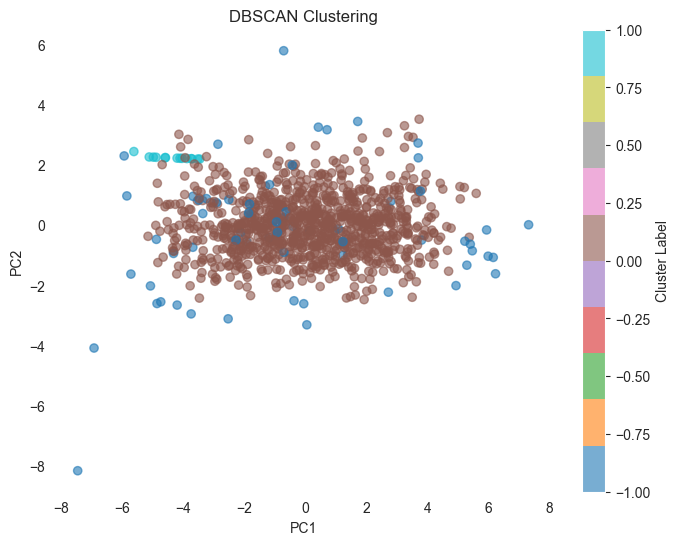

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

db = DBSCAN(eps=1.0, min_samples=5).fit(X_pca)  # or X_umap for better results
labels_dbscan = db.labels_

# Silhouette score (ignoring noise points labeled -1)
if len(set(labels_dbscan)) > 1:
    score = silhouette_score(X_pca, labels_dbscan)
    print("Silhouette Score (DBSCAN):", round(score, 2))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='tab10', alpha=0.6)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label")
plt.show()


In [ ]:
### Agglomerative Clustering (Hierarchical)

### Gaussian Mixture Models (GMM)

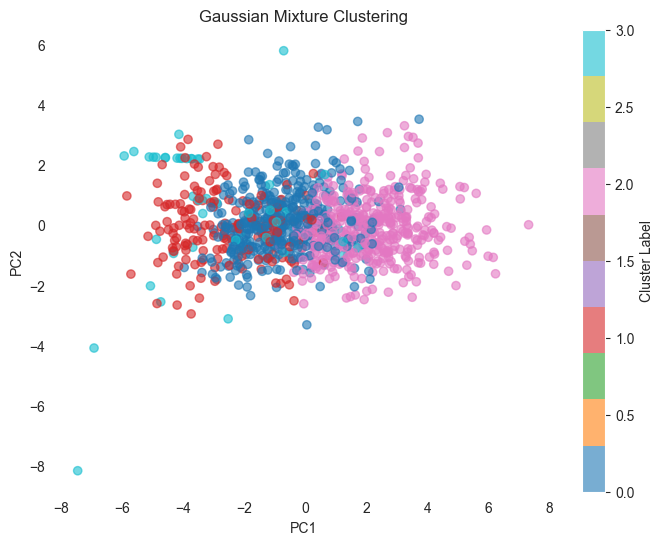

In [57]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=0)
labels_gmm = gmm.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap='tab10', alpha=0.6)
plt.title("Gaussian Mixture Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.show()


### Isolation Forest for Exploratory Anomaly Detection

ValueError: 'c' argument has 1582 elements, which is inconsistent with 'x' and 'y' with size 1028.

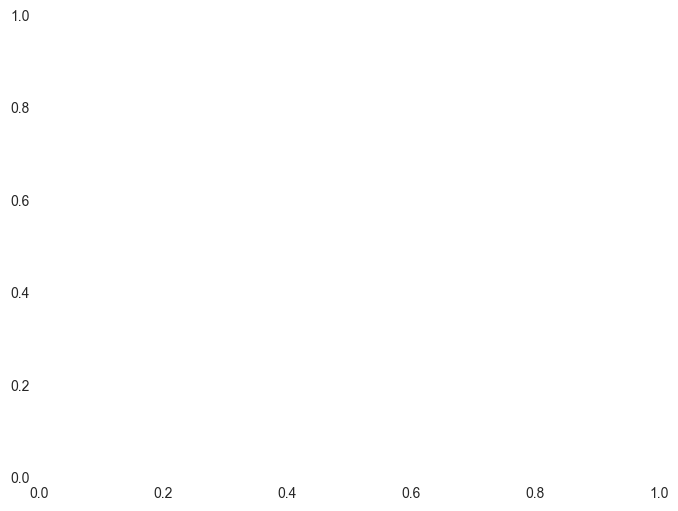

In [58]:
from sklearn.ensemble import IsolationForest

# Fit model
iso = IsolationForest(contamination=0.1, random_state=0)
df_standardized["anomaly_score"] = iso.fit_predict(df_standardized[after_cor_checking_vars])

# Visualize with PCA or UMAP
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_standardized["anomaly_score"], cmap='coolwarm', alpha=0.6)
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="Anomaly Score")
plt.show()


In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized[after_cor_checking_vars])
df_standardized['cluster'] = cluster_labels


In [60]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(df_standardized[after_cor_checking_vars], df_standardized['cluster'])
feature_importances = rf.feature_importances_
feature_importances


array([0.03598865, 0.10462481, 0.06390375, 0.16326632, 0.15106535,
       0.09589369, 0.05615197, 0.12113321, 0.02651267, 0.18145957])

In [61]:
# Create a DataFrame to show importance
importance_df = pd.DataFrame({
    'Feature': after_cor_checking_vars,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                          Feature  Importance
9                 BLINK_COUNT_log    0.181460
3  AVERAGE_SACCADE_AMPLITUDE_sqrt    0.163266
4   MEDIAN_SACCADE_AMPLITUDE_sqrt    0.151065
7                  PUPIL_SIZE_MIN    0.121133
1              FIXATION_COUNT_log    0.104625
5            SD_SACCADE_AMPLITUDE    0.095894
2       FIXATION_DURATION_MIN_log    0.063904
6                 PUPIL_SIZE_MEAN    0.056152
0   AVERAGE_FIXATION_DURATION_log    0.035989
8      AVERAGE_BLINK_DURATION_log    0.026513


### Use accuracy as supervised label

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


numeric_cols = after_cor_checking_vars.copy()
df_final = df_standardized.copy()

# 1. Define X and y
X = df_final[numeric_cols]
y = df_final['response']  # or 'accuracy', assuming 0/1 values

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Fit a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 4. Evaluate performance
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.67      0.62       252
           1       0.55      0.45      0.50       223

    accuracy                           0.57       475
   macro avg       0.56      0.56      0.56       475
weighted avg       0.56      0.57      0.56       475

[[168  84]
 [122 101]]


In [63]:
importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(20))


                          Feature  Importance
0   AVERAGE_FIXATION_DURATION_log    0.125806
1              FIXATION_COUNT_log    0.125578
3  AVERAGE_SACCADE_AMPLITUDE_sqrt    0.114668
4   MEDIAN_SACCADE_AMPLITUDE_sqrt    0.107846
6                 PUPIL_SIZE_MEAN    0.105414
7                  PUPIL_SIZE_MIN    0.098516
5            SD_SACCADE_AMPLITUDE    0.095461
2       FIXATION_DURATION_MIN_log    0.093469
8      AVERAGE_BLINK_DURATION_log    0.089984
9                 BLINK_COUNT_log    0.043258


In [64]:
# Aggregate features per participant or per task
agg_df = df_final.groupby('RECORDING_SESSION_LABEL').agg({
    'FIXATION_COUNT_log': ['mean', 'std'],
    'PUPIL_SIZE_MEAN': ['mean', 'std'],
    ...
    'response': 'mean'  # This becomes your aggregated score
})
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]


SyntaxError: ':' expected after dictionary key (978716447.py, line 5)